In [1]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import re
import nltk
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import time 


### Importing of Kaggle Repository Twitter Dataset

In this Classification Task, we are trying to train a model to classify our crawled dataset whether the tweets are subjective or objective, positive or negative sentiments

In [2]:
df_tweet = pd.read_csv("Tweet.csv")

In [3]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3717964 entries, 0 to 3717963
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   tweet_id     int64 
 1   writer       object
 2   post_date    int64 
 3   body         object
 4   comment_num  int64 
 5   retweet_num  int64 
 6   like_num     int64 
dtypes: int64(5), object(2)
memory usage: 198.6+ MB


In [4]:
df_tweet.head()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


In [5]:
df_company_tweet = pd.read_csv("Company_Tweet.csv")

In [6]:
df_company_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336445 entries, 0 to 4336444
Data columns (total 2 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   tweet_id       int64 
 1   ticker_symbol  object
dtypes: int64(1), object(1)
memory usage: 66.2+ MB


In [7]:
df_company_tweet.head()

,tweet_id,ticker_symbol
0,550803612197457920,AAPL
1,550803610825928706,AAPL
2,550803225113157632,AAPL
3,550802957370159104,AAPL
4,550802855129382912,AAPL


In [8]:
tweets = pd.merge(df_company_tweet,df_tweet,on= "tweet_id", how = "inner")

In [9]:
tweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
0,550803612197457920,AAPL,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
1,550803612197457920,AMZN,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
2,550803610825928706,AAPL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
3,550803610825928706,GOOGL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
4,550803610825928706,AMZN,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1


### Importing of Crawled Twitter Dataset

This is the crawled dataset from twitter with regards to stocks such as AAPL, AMZN, MSFT, TSLA, GOOGL

In [10]:
aapl_df = pd.read_csv("AAPL.csv")
amzn_df = pd.read_csv("AMZN.csv")
msft_df = pd.read_csv("MSFT.csv")
tsla_df = pd.read_csv("TSLA.csv")
googl_df = pd.read_csv("GOOGL.csv")

In [11]:
aapl_df["ticker_symbol"] = "AAPL"
amzn_df["ticker_symbol"] = "AMZN"
msft_df["ticker_symbol"] = "MSFT"
tsla_df["ticker_symbol"] = "TSLA"
googl_df["ticker_symbol"] = "GOOGL"

In [12]:
crawled_tweets = pd.concat([aapl_df, amzn_df, msft_df, tsla_df, googl_df], axis = 0)

In [13]:
crawled_tweets.reset_index(drop = True, inplace= True)


In [14]:
crawled_tweets.tail()

,date,id,user,tweet,likes,replies,retweets,ticker_symbol
7373,2023-02-28 04:39:48+00:00,1630427525334564871,ProfitsTaken,⚡️ Youtube video up and live for 2.27.2023! \n...,32,2,8,GOOGL
7374,2023-02-28 02:20:32+00:00,1630392478833451008,FIREDUpWealth,DoJ accuses Google of deleting chats in its an...,11,0,1,GOOGL
7375,2023-02-28 02:19:17+00:00,1630392162876637184,FIREDUpWealth,#Waymo to test driverless rides with employees...,14,2,1,GOOGL
7376,2023-02-28 01:56:07+00:00,1630386331087151106,data168,Not sure if anyone uses YouTube to listen to m...,39,14,0,GOOGL
7377,2023-02-28 00:53:53+00:00,1630370673175699457,tomthetrader1,Google was firmly rejected and is now approach...,30,2,5,GOOGL


In [15]:
def datasetInfo(dataset):
    print(f" Dataset Information and type \n {dataset.info()}")
    print("--------------------------------------------------------\n\n Data Types: ")
    print(dataset.dtypes)
    print("--------------------------------------------------------\n\n Rows and Columns: ")
    print(dataset.shape)
    print("--------------------------------------------------------\n\n Column Names: ")
    print(dataset.columns)
    print("--------------------------------------------------------\n\n Null Values: ")
    print(dataset.apply(lambda x: sum(x.isnull()) / len(dataset)))
    print("--------------------------------------------------------\n\n Unique Values: ")
    print(dataset.nunique())
    print("--------------------------------------------------------\n\n Describe: ")
    print(dataset.describe())

In [16]:
datasetInfo(tweets)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4336445 entries, 0 to 4336444
Data columns (total 8 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   tweet_id       int64 
 1   ticker_symbol  object
 2   writer         object
 3   post_date      int64 
 4   body           object
 5   comment_num    int64 
 6   retweet_num    int64 
 7   like_num       int64 
dtypes: int64(5), object(3)
memory usage: 297.8+ MB
 Dataset Information and type 
 None
--------------------------------------------------------

 Data Types: 
tweet_id          int64
ticker_symbol    object
writer           object
post_date         int64
body             object
comment_num       int64
retweet_num       int64
like_num          int64
dtype: object
--------------------------------------------------------

 Rows and Columns: 
(4336445, 8)
--------------------------------------------------------

 Column Names: 
Index(['tweet_id', 'ticker_symbol', 'writer', 'post_date', 'body',
       'comment_num

In [17]:
datasetInfo(crawled_tweets)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7378 entries, 0 to 7377
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           7378 non-null   object
 1   id             7378 non-null   int64 
 2   user           7378 non-null   object
 3   tweet          7378 non-null   object
 4   likes          7378 non-null   int64 
 5   replies        7378 non-null   int64 
 6   retweets       7378 non-null   int64 
 7   ticker_symbol  7378 non-null   object
dtypes: int64(4), object(4)
memory usage: 461.2+ KB
 Dataset Information and type 
 None
--------------------------------------------------------

 Data Types: 
date             object
id                int64
user             object
tweet            object
likes             int64
replies           int64
retweets          int64
ticker_symbol    object
dtype: object
--------------------------------------------------------

 Rows and Columns: 
(7378, 8)
---------

After Merging Remove the dataframes that columns are empty

In [18]:
tweets.dropna(inplace = True)

In [19]:
crawled_tweets.dropna(inplace = True)

Convert our tweet date_time into just date

In [20]:
tweets['post_date'] = pd.to_datetime(tweets["post_date"],utc = False , unit = 's',).dt.normalize()
tweets['post_date'] = tweets["post_date"].dt.date
tweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
0,550803612197457920,AAPL,SentiQuant,2015-01-01,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
1,550803612197457920,AMZN,SentiQuant,2015-01-01,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
2,550803610825928706,AAPL,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
3,550803610825928706,GOOGL,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
4,550803610825928706,AMZN,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1


In [21]:
crawled_tweets['date'] = pd.to_datetime(crawled_tweets['date'])
crawled_tweets['date'] = crawled_tweets['date'].dt.date

We need to differentiate active tweets which are more "Reputable" compared to botting tweets or spams. <br>
Activities can be defined as comments/replies, retweets, and likes.

In [22]:
tweets.sort_values(by = "comment_num" , ascending  = False, inplace = True)
tweets


,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,"I’d just like to point out that right now, rig...",631,369,0
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,"If a Tesla saves you $200 a month on gas, you ...",567,0,0
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,~Tesla feature request thread~Feel free to rep...,563,48,662
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,"""I sell books."" versus ""I sell whatever the fu...",496,0,0
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,“I think it's basically financially insane to ...,442,0,0
...,...,...,...,...,...,...,...,...
1488123,1060565704389378055,AAPL,ScottSegen,2018-11-08,Mark Zuckerberg turns down UK parliament reque...,0,0,1
1488124,1060565704389378055,GOOGL,ScottSegen,2018-11-08,Mark Zuckerberg turns down UK parliament reque...,0,0,1
1488125,1060566279818366977,AAPL,jordanladz,2018-11-08,Get audible updates with this new application....,0,0,0
1488126,1060566346763849735,AAPL,CompoundFreedom,2018-11-08,Apple Opens First Store in Thailand Saturday h...,0,0,0


In [23]:
crawled_tweets.sort_values(by = "replies" , ascending  = False, inplace = True)
crawled_tweets

,date,id,user,tweet,likes,replies,retweets,ticker_symbol
5493,2023-02-07,1623104847309594626,stevenmarkryan,What is your avg cost for $TSLA?,533,934,18,TSLA
4507,2023-01-05,1611144585966911491,farzyness,"When you own a Tesla, you never have to visit ...",4522,830,361,TSLA
5585,2023-02-10,1624190414906613761,GerberKawasaki,It’s time for retail investors to have a real ...,1193,792,81,TSLA
5682,2023-02-13,1625274047272738816,GerberKawasaki,Tesla was down today post super bowl in a very...,554,770,40,TSLA
5801,2023-02-17,1626721213895823361,WholeMarsBlog,Tesla Autopilot Hardware 3 will NEVER be able ...,3768,731,431,TSLA
...,...,...,...,...,...,...,...,...
5049,2023-01-23,1617662159806410753,HeartDocTesla,Stocks rally. Default is MSM must create a neg...,9,0,1,TSLA
6348,2023-01-15,1614662694262407168,OptionsMike,$GOOGL remains a lagger in tech. 50D almost th...,10,0,3,GOOGL
6347,2023-01-15,1614676421208866818,TogetherWeTrad3,$GOOGL https://t.co/zpvbKIrA98,15,0,2,GOOGL
1298,2023-02-16,1626296950562619392,AhmedAbouhalawa,@thejefflutz @elonmusk @skorusARK We must shor...,37,0,0,AAPL


The tweet activities will be defined by the summation of all comments/replies, likes and retweets to differentiate from bots or spams, where tweets are more "usable" for sentimental analysis

In [24]:
tweets["tweet_activity"] = tweets["comment_num"] + tweets["like_num"] + tweets["retweet_num"]
tweets

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,"I’d just like to point out that right now, rig...",631,369,0,1000
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,"If a Tesla saves you $200 a month on gas, you ...",567,0,0,567
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,~Tesla feature request thread~Feel free to rep...,563,48,662,1273
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,"""I sell books."" versus ""I sell whatever the fu...",496,0,0,496
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,“I think it's basically financially insane to ...,442,0,0,442
...,...,...,...,...,...,...,...,...,...
1488123,1060565704389378055,AAPL,ScottSegen,2018-11-08,Mark Zuckerberg turns down UK parliament reque...,0,0,1,1
1488124,1060565704389378055,GOOGL,ScottSegen,2018-11-08,Mark Zuckerberg turns down UK parliament reque...,0,0,1,1
1488125,1060566279818366977,AAPL,jordanladz,2018-11-08,Get audible updates with this new application....,0,0,0,0
1488126,1060566346763849735,AAPL,CompoundFreedom,2018-11-08,Apple Opens First Store in Thailand Saturday h...,0,0,0,0


In [25]:
crawled_tweets["tweet_activity"] = crawled_tweets["replies"] + crawled_tweets["likes"] + crawled_tweets["retweets"]
crawled_tweets

,date,id,user,tweet,likes,replies,retweets,ticker_symbol,tweet_activity
5493,2023-02-07,1623104847309594626,stevenmarkryan,What is your avg cost for $TSLA?,533,934,18,TSLA,1485
4507,2023-01-05,1611144585966911491,farzyness,"When you own a Tesla, you never have to visit ...",4522,830,361,TSLA,5713
5585,2023-02-10,1624190414906613761,GerberKawasaki,It’s time for retail investors to have a real ...,1193,792,81,TSLA,2066
5682,2023-02-13,1625274047272738816,GerberKawasaki,Tesla was down today post super bowl in a very...,554,770,40,TSLA,1364
5801,2023-02-17,1626721213895823361,WholeMarsBlog,Tesla Autopilot Hardware 3 will NEVER be able ...,3768,731,431,TSLA,4930
...,...,...,...,...,...,...,...,...,...
5049,2023-01-23,1617662159806410753,HeartDocTesla,Stocks rally. Default is MSM must create a neg...,9,0,1,TSLA,10
6348,2023-01-15,1614662694262407168,OptionsMike,$GOOGL remains a lagger in tech. 50D almost th...,10,0,3,GOOGL,13
6347,2023-01-15,1614676421208866818,TogetherWeTrad3,$GOOGL https://t.co/zpvbKIrA98,15,0,2,GOOGL,17
1298,2023-02-16,1626296950562619392,AhmedAbouhalawa,@thejefflutz @elonmusk @skorusARK We must shor...,37,0,0,AAPL,37


### Filter Tweets that are >= 50 activities

In [26]:
filterTweets = tweets.loc[tweets["tweet_activity"] > 50]

In [27]:
filterCrawledTweets = crawled_tweets.loc[crawled_tweets["tweet_activity"] > 50]

In [28]:
filterTweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,"I’d just like to point out that right now, rig...",631,369,0,1000
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,"If a Tesla saves you $200 a month on gas, you ...",567,0,0,567
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,~Tesla feature request thread~Feel free to rep...,563,48,662,1273
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,"""I sell books."" versus ""I sell whatever the fu...",496,0,0,496
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,“I think it's basically financially insane to ...,442,0,0,442


In [29]:
filterCrawledTweets.head()

,date,id,user,tweet,likes,replies,retweets,ticker_symbol,tweet_activity
5493,2023-02-07,1623104847309594626,stevenmarkryan,What is your avg cost for $TSLA?,533,934,18,TSLA,1485
4507,2023-01-05,1611144585966911491,farzyness,"When you own a Tesla, you never have to visit ...",4522,830,361,TSLA,5713
5585,2023-02-10,1624190414906613761,GerberKawasaki,It’s time for retail investors to have a real ...,1193,792,81,TSLA,2066
5682,2023-02-13,1625274047272738816,GerberKawasaki,Tesla was down today post super bowl in a very...,554,770,40,TSLA,1364
5801,2023-02-17,1626721213895823361,WholeMarsBlog,Tesla Autopilot Hardware 3 will NEVER be able ...,3768,731,431,TSLA,4930


### Data Cleaning and Tokenization of text body

In [30]:
# Function to remove stopwords (common english stopwords from nltk)
from nltk.corpus import stopwords

def removeStopWords(df):
    finalList = []
    stop_words = set(stopwords.words('english'))
    for word in df:
        if word not in stop_words:
            finalList.append(word)
    df = finalList
    return df

In [31]:
# Function to stem tweets 
from nltk.stem.porter import *

def stem_text(text):
    
    stemmer = PorterStemmer()
   
    return [stemmer.stem(word) for word in text]

In [32]:
# Function to lemmatise tweets
def lemmatised_text(text):
    lemmatiser = nltk.stem.WordNetLemmatizer()
    return [lemmatiser.lemmatize(word) for word in text]

In [33]:
def clean_dataframe_text(df, column,lemma):
    
    # Define regex pattern to match URLs
    url_pattern = r"https?://\S+"
    
    # Remove URLs from text column
    df[column] = df[column].str.replace(url_pattern, "", regex=True)
    
    # Remove any non-alphanumeric characters and replace them with spaces
    df[column] = df[column].apply(lambda x: re.sub(r"(\w+)'d", lambda m: 'would' if m.group(1) in ['he', 'she', 'it', 'that'] else 'had', x))
    
    # Replace 's with 'is' or 'has'
    df[column] = df[column].apply(lambda x: re.sub(r"(\w+)'s", lambda m: 'is' if m.group(1) in ['he', 'she', 'it'] else 'has', x))
    
    # Remove any non-alphanumeric characters and replace them with spaces
    df[column] = df[column].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    
    # Replace any consecutive whitespace characters with a single space
    df[column] = df[column].apply(lambda x: re.sub(r'\s+', ' ', x))
    
    # Remove not word characters
    df[column] = df[column].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
    
       
    # Remove digits 
    df[column] = df[column].apply(lambda x: re.sub(r'\d+', '', x))
    
    # Convert the string in lower
    df[column] = df[column].str.lower()
    
    # Tokenised the words
    df[column]  = df[column].apply(lambda x : nltk.word_tokenize(x))

    # Remove stopwords from the NLTK stopword list
    df[column] = df[column].apply(lambda x : removeStopWords(x))
    
    if lemma:
    # lemmatised the text
        df[column] = df[column].apply(lambda x : lemmatised_text(x))
    else:
    # Stemmed the text
        df[column] = df[column].apply(lambda x : stem_text(x))
    #concatenate the tokenised list into string
    df[column] = df[column].apply(lambda x: ' '.join(x))
    
      
    return df

In [34]:
# Tweets that are cleaned and lemmatised
filterTweetsLemma = filterTweets.copy()
filterTweetsLemma = clean_dataframe_text(filterTweetsLemma,"body",True)
filterTweetsLemma.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk goin...,631,369,0,1000
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month gas ten year take saving put ...,567,0,0,567
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla feature request threadfeel free reply il...,563,48,662,1273
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versus sell whatever fuck want amzn,496,0,0,496
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basically financially insane buy anythin...,442,0,0,442


In [35]:
# Tweets that are cleaned and stemmed
filterTweets = clean_dataframe_text(filterTweets,"body",False)
filterTweets.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_12516\4015562605.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].str.replace(url_pattern, "", regex=True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_12516\4015562605.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: re.sub(r"(\w+)'d", lambda m: 'would' if m.group(1) in ['he', 'she', 'it', 'that'] else 'had', x))
C:\Users\eric2\AppData\Local\Temp\ipykernel_12516\4015562605.py:13: SettingWithCop

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442


In [36]:
filterTweets["body"].head()

3786974    id like point right right moment elonmusk go f...
4112626    tesla save month ga ten year take save put bal...
4306536    tesla featur request threadfeel free repli ill...
2823018           sell book versu sell whatev fuck want amzn
4182686    think basic financi insan buy anyth except ele...
Name: body, dtype: object

In [37]:
filterCrawledTweetsLemma = filterCrawledTweets.copy()
filterCrawledTweetsLemma = clean_dataframe_text(filterCrawledTweetsLemma, "tweet", True)
filterCrawledTweetsLemma.head()

,date,id,user,tweet,likes,replies,retweets,ticker_symbol,tweet_activity
5493,2023-02-07,1623104847309594626,stevenmarkryan,avg cost tsla,533,934,18,TSLA,1485
4507,2023-01-05,1611144585966911491,farzyness,tesla never visit gas station leave everyday f...,4522,830,361,TSLA,5713
5585,2023-02-10,1624190414906613761,GerberKawasaki,time retail investor real voice feel huge asse...,1193,792,81,TSLA,2066
5682,2023-02-13,1625274047272738816,GerberKawasaki,tesla today post super bowl strong market thou...,554,770,40,TSLA,1364
5801,2023-02-17,1626721213895823361,WholeMarsBlog,tesla autopilot hardware never able drive arou...,3768,731,431,TSLA,4930


In [38]:
filterCrawledTweets= clean_dataframe_text(filterCrawledTweets, "tweet", False)
filterCrawledTweets.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_12516\4015562605.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].str.replace(url_pattern, "", regex=True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_12516\4015562605.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: re.sub(r"(\w+)'d", lambda m: 'would' if m.group(1) in ['he', 'she', 'it', 'that'] else 'had', x))
C:\Users\eric2\AppData\Local\Temp\ipykernel_12516\4015562605.py:13: SettingWithCop

,date,id,user,tweet,likes,replies,retweets,ticker_symbol,tweet_activity
5493,2023-02-07,1623104847309594626,stevenmarkryan,avg cost tsla,533,934,18,TSLA,1485
4507,2023-01-05,1611144585966911491,farzyness,tesla never visit ga station leav everyday ful...,4522,830,361,TSLA,5713
5585,2023-02-10,1624190414906613761,GerberKawasaki,time retail investor real voic feel huge asset...,1193,792,81,TSLA,2066
5682,2023-02-13,1625274047272738816,GerberKawasaki,tesla today post super bowl strong market thou...,554,770,40,TSLA,1364
5801,2023-02-17,1626721213895823361,WholeMarsBlog,tesla autopilot hardwar never abl drive around...,3768,731,431,TSLA,4930


### Tweet EDA

In [39]:
filterTweets["writer"].describe()


count           41625
unique           2797
top       TESLAcharts
freq             2212
Name: writer, dtype: object

In [40]:
filterCrawledTweets["user"].describe()

count             2137
unique             648
top       StockMKTNewz
freq               109
Name: user, dtype: object

### Writer Data Exploration

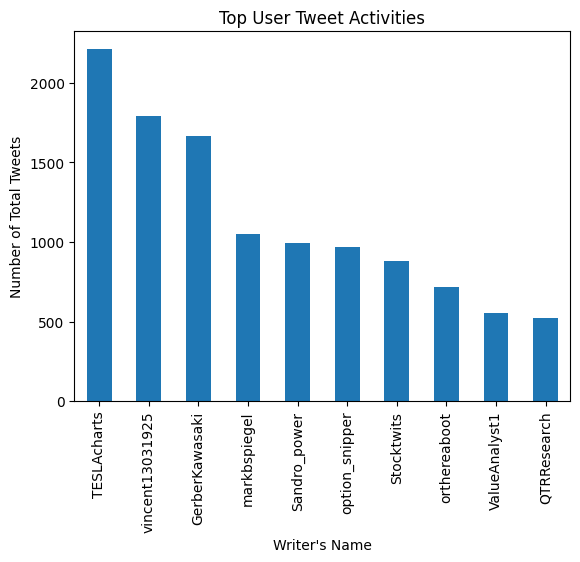

In [41]:

counts = filterTweets["writer"].value_counts(ascending= False)
countsFilter = counts[:10]
countsFilter.plot(kind="bar")

plt.title("Top User Tweet Activities")
plt.ylabel("Number of Total Tweets")
plt.xlabel("Writer's Name")
plt.show()

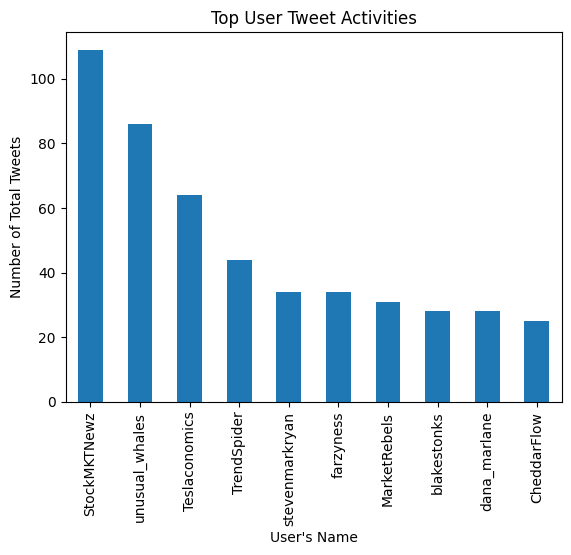

In [42]:
counts = filterCrawledTweets["user"].value_counts(ascending= False)
countsFilter = counts[:10]
countsFilter.plot(kind="bar")

plt.title("Top User Tweet Activities")
plt.ylabel("Number of Total Tweets")
plt.xlabel("User's Name")
plt.show()

Graph above shows active users/writers

<AxesSubplot: ylabel='ticker_symbol'>

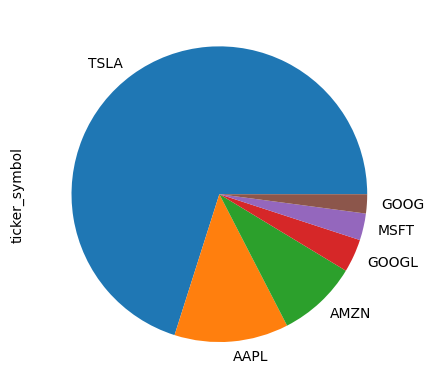

In [43]:
counts = filterTweets["ticker_symbol"].value_counts()
counts.plot(kind="pie")

<AxesSubplot: ylabel='ticker_symbol'>

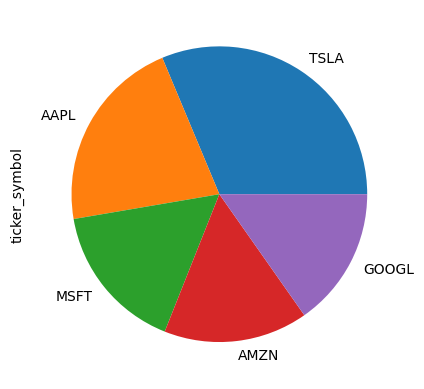

In [44]:
counts = filterCrawledTweets["ticker_symbol"].value_counts()
counts.plot(kind="pie")

Notice that there are more TSLA tweets in the dataset.

### Active Tweets dates

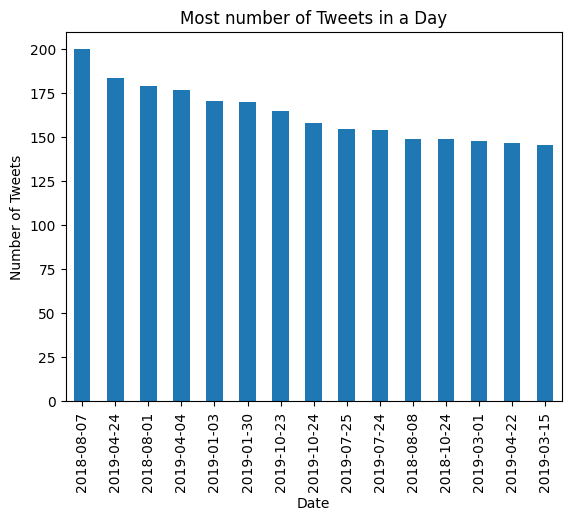

In [45]:
count = filterTweets["post_date"].value_counts(ascending = False)
count
filterCounts = count[:15]
filterCounts.plot(kind = "bar")
plt.title("Most number of Tweets in a Day")
plt.ylabel("Number of Tweets")
plt.xlabel("Date")
plt.show()

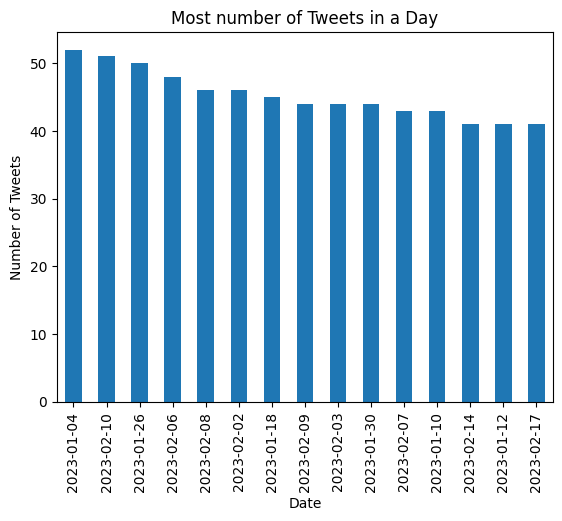

In [46]:
count = filterCrawledTweets["date"].value_counts(ascending = False)
count
filterCounts = count[:15]
filterCounts.plot(kind = "bar")
plt.title("Most number of Tweets in a Day")
plt.ylabel("Number of Tweets")
plt.xlabel("Date")
plt.show()

Above bar graphs shows the highest tweets in the respective days

### Word Cloud of Tweets

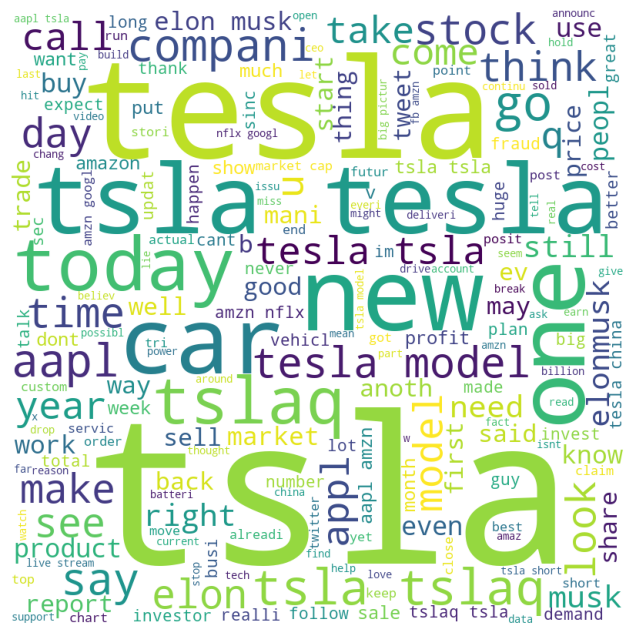

In [47]:
text = " ".join(filterTweets["body"])
wordcloud = WordCloud(width = 800, height = 800, background_color='white', max_words = 200)
wordcloud.generate(text)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

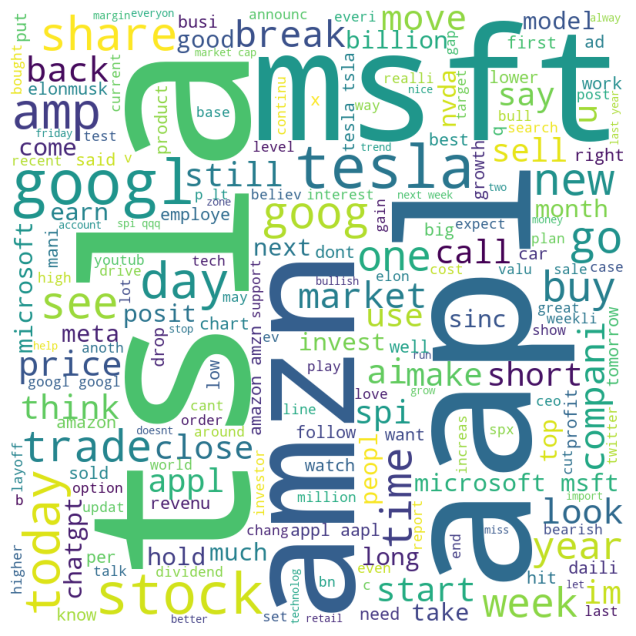

In [48]:
text = " ".join(filterCrawledTweets["tweet"])
wordcloud = WordCloud(width = 800, height = 800, background_color='white', max_words = 200)
wordcloud.generate(text)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

From the word cloud we can tell that tsla aapl msft are common tweets in Twitter

# Polarity Detection

### Subjectivity and Polarity Analysis using Textblob

In [49]:
from textblob import TextBlob

In [50]:
# Function to use TextBlob (Sentimental Analysis [Objectivity & Polarity])

def add_sentiment_scores_blob(df, text_column, polarity_threshold = 0.0 , subjectivity_threshold = 0.5):
    # Compute polarity and subjectivity scores for each row in the specified text column
    scores = df[text_column].apply(lambda x: TextBlob(x).sentiment)
    
    # Add two new columns to the DataFrame for the polarity and subjectivity scores
    df['blob_polarity'] = scores.apply(lambda x: x.polarity)
    df['blob_subjectivity'] = scores.apply(lambda x: x.subjectivity)
    
    # Convert polarity score to class (positive, neutral, or negative) based on the specified threshold
    df['blob_polarity'] = df['blob_polarity'].apply(lambda x: 'Positive' if x > polarity_threshold else 'Negative' if x < -polarity_threshold else 'Neutral')
    
    # Convert subjectivity score to class (subjective or objective) based on the specified threshold
    df['blob_subjectivity'] = df['blob_subjectivity'].apply(lambda x: 'Subjective' if x > subjectivity_threshold else 'Objective')
    
    return df
    
    

In [51]:
add_sentiment_scores_blob(filterTweets,"body", 0.0, 0.5)
filterTweets.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_12516\2951990553.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blob_polarity'] = scores.apply(lambda x: x.polarity)
C:\Users\eric2\AppData\Local\Temp\ipykernel_12516\2951990553.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blob_subjectivity'] = scores.apply(lambda x: x.subjectivity)
C:\Users\eric2\AppData\Local\Temp\ipykernel_12516\2951990553.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,blob_polarity,blob_subjectivity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000,Positive,Subjective
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567,Positive,Objective
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273,Negative,Subjective
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496,Negative,Subjective
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442,Negative,Objective


In [52]:
add_sentiment_scores_blob(filterTweetsLemma,"body", 0.0, 0.5)
filterTweetsLemma.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,blob_polarity,blob_subjectivity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk goin...,631,369,0,1000,Positive,Subjective
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month gas ten year take saving put ...,567,0,0,567,Positive,Objective
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla feature request threadfeel free reply il...,563,48,662,1273,Negative,Subjective
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versus sell whatever fuck want amzn,496,0,0,496,Negative,Subjective
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basically financially insane buy anythin...,442,0,0,442,Negative,Subjective


In [53]:
add_sentiment_scores_blob(filterCrawledTweetsLemma,"tweet", 0.0, 0.5)
filterCrawledTweetsLemma.head()

,date,id,user,tweet,likes,replies,retweets,ticker_symbol,tweet_activity,blob_polarity,blob_subjectivity
5493,2023-02-07,1623104847309594626,stevenmarkryan,avg cost tsla,533,934,18,TSLA,1485,Neutral,Objective
4507,2023-01-05,1611144585966911491,farzyness,tesla never visit gas station leave everyday f...,4522,830,361,TSLA,5713,Positive,Subjective
5585,2023-02-10,1624190414906613761,GerberKawasaki,time retail investor real voice feel huge asse...,1193,792,81,TSLA,2066,Positive,Objective
5682,2023-02-13,1625274047272738816,GerberKawasaki,tesla today post super bowl strong market thou...,554,770,40,TSLA,1364,Positive,Subjective
5801,2023-02-17,1626721213895823361,WholeMarsBlog,tesla autopilot hardware never able drive arou...,3768,731,431,TSLA,4930,Negative,Objective


In [54]:
add_sentiment_scores_blob(filterCrawledTweets,"tweet", 0.0, 0.5)
filterCrawledTweets.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_12516\2951990553.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blob_polarity'] = scores.apply(lambda x: x.polarity)
C:\Users\eric2\AppData\Local\Temp\ipykernel_12516\2951990553.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blob_subjectivity'] = scores.apply(lambda x: x.subjectivity)
C:\Users\eric2\AppData\Local\Temp\ipykernel_12516\2951990553.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,date,id,user,tweet,likes,replies,retweets,ticker_symbol,tweet_activity,blob_polarity,blob_subjectivity
5493,2023-02-07,1623104847309594626,stevenmarkryan,avg cost tsla,533,934,18,TSLA,1485,Neutral,Objective
4507,2023-01-05,1611144585966911491,farzyness,tesla never visit ga station leav everyday ful...,4522,830,361,TSLA,5713,Positive,Subjective
5585,2023-02-10,1624190414906613761,GerberKawasaki,time retail investor real voic feel huge asset...,1193,792,81,TSLA,2066,Positive,Objective
5682,2023-02-13,1625274047272738816,GerberKawasaki,tesla today post super bowl strong market thou...,554,770,40,TSLA,1364,Positive,Subjective
5801,2023-02-17,1626721213895823361,WholeMarsBlog,tesla autopilot hardwar never abl drive around...,3768,731,431,TSLA,4930,Neutral,Objective


### Convert Positive, Negative and Neutral to numeral labels and Subjectivity

In [55]:
sentiment_map = ["Negative", "Neutral","Positive"]
subjectivity_mapping = {"Subjective": 1, "Objective": 0}


In [56]:


filterTweets["blob_subjectivity"].replace(subjectivity_mapping, inplace = True)
filterTweets = pd.get_dummies(filterTweets, columns = ["blob_polarity"])
filterTweets.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_12516\707693292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterTweets["blob_subjectivity"].replace(subjectivity_mapping, inplace = True)


,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,blob_subjectivity,blob_polarity_Negative,blob_polarity_Neutral,blob_polarity_Positive
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000,1,0,0,1
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567,0,0,0,1
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273,1,1,0,0
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496,1,1,0,0
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442,0,1,0,0


In [57]:

filterTweetsLemma = pd.get_dummies(filterTweetsLemma , columns = ["blob_polarity"])
filterTweetsLemma["blob_subjectivity"].replace(subjectivity_mapping, inplace = True)
filterTweetsLemma.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,blob_subjectivity,blob_polarity_Negative,blob_polarity_Neutral,blob_polarity_Positive
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk goin...,631,369,0,1000,1,0,0,1
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month gas ten year take saving put ...,567,0,0,567,0,0,0,1
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla feature request threadfeel free reply il...,563,48,662,1273,1,1,0,0
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versus sell whatever fuck want amzn,496,0,0,496,1,1,0,0
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basically financially insane buy anythin...,442,0,0,442,1,1,0,0


In [58]:

filterCrawledTweetsLemma = pd.get_dummies(filterCrawledTweetsLemma, columns = ["blob_polarity"])
filterCrawledTweetsLemma["blob_subjectivity"].replace(subjectivity_mapping, inplace = True)
filterCrawledTweetsLemma.head()

,date,id,user,tweet,likes,replies,retweets,ticker_symbol,tweet_activity,blob_subjectivity,blob_polarity_Negative,blob_polarity_Neutral,blob_polarity_Positive
5493,2023-02-07,1623104847309594626,stevenmarkryan,avg cost tsla,533,934,18,TSLA,1485,0,0,1,0
4507,2023-01-05,1611144585966911491,farzyness,tesla never visit gas station leave everyday f...,4522,830,361,TSLA,5713,1,0,0,1
5585,2023-02-10,1624190414906613761,GerberKawasaki,time retail investor real voice feel huge asse...,1193,792,81,TSLA,2066,0,0,0,1
5682,2023-02-13,1625274047272738816,GerberKawasaki,tesla today post super bowl strong market thou...,554,770,40,TSLA,1364,1,0,0,1
5801,2023-02-17,1626721213895823361,WholeMarsBlog,tesla autopilot hardware never able drive arou...,3768,731,431,TSLA,4930,0,1,0,0


In [59]:

filterCrawledTweets = pd.get_dummies(filterCrawledTweets, columns = ["blob_polarity"])
filterCrawledTweets["blob_subjectivity"].replace(subjectivity_mapping, inplace = True)
filterCrawledTweets.head()

,date,id,user,tweet,likes,replies,retweets,ticker_symbol,tweet_activity,blob_subjectivity,blob_polarity_Negative,blob_polarity_Neutral,blob_polarity_Positive
5493,2023-02-07,1623104847309594626,stevenmarkryan,avg cost tsla,533,934,18,TSLA,1485,0,0,1,0
4507,2023-01-05,1611144585966911491,farzyness,tesla never visit ga station leav everyday ful...,4522,830,361,TSLA,5713,1,0,0,1
5585,2023-02-10,1624190414906613761,GerberKawasaki,time retail investor real voic feel huge asset...,1193,792,81,TSLA,2066,0,0,0,1
5682,2023-02-13,1625274047272738816,GerberKawasaki,tesla today post super bowl strong market thou...,554,770,40,TSLA,1364,1,0,0,1
5801,2023-02-17,1626721213895823361,WholeMarsBlog,tesla autopilot hardwar never abl drive around...,3768,731,431,TSLA,4930,0,0,1,0


### Splitting up data for Prediction using ensemble machine learning models For Blob Subjectivity and Polarity Analysis

In [60]:
X = filterTweets["body"].values 
y = filterTweets[["blob_polarity_Negative", "blob_polarity_Neutral", "blob_polarity_Positive"]].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0)

In [61]:
X_lemma = filterTweetsLemma["body"].values 
y_lemma = filterTweetsLemma[["blob_polarity_Negative", "blob_polarity_Neutral", "blob_polarity_Positive"]].values
X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma = train_test_split(
    X_lemma, y_lemma, test_size=0.20, random_state=0)

In [62]:
X_subj = filterTweets["body"].values 
y_subj = filterTweets["blob_subjectivity"].values
X_train_subj, X_test_subj, y_train_subj, y_test_subj = train_test_split(
    X_subj, y_subj, test_size=0.20, random_state=0)

In [63]:
X_subj_lemma = filterTweetsLemma["body"].values 
y_subj_lemma = filterTweetsLemma["blob_subjectivity"].values
X_train_subj_lemma, X_test_subj_lemma, y_train_subj_lemma, y_test_subj_lemma = train_test_split(
    X_subj_lemma, y_subj_lemma, test_size=0.20, random_state=0)

In [64]:
X_crawled = filterCrawledTweets["tweet"].values 
y_crawled = filterCrawledTweets[["blob_polarity_Negative", "blob_polarity_Neutral", "blob_polarity_Positive"]].values
X_train_crawled, X_test_crawled, y_train_crawled, y_test_crawled = train_test_split(
    X_crawled, y_crawled, test_size=0.20, random_state=0)

In [65]:
X_lemma_crawled = filterCrawledTweetsLemma["tweet"].values #["ticker_symbol","writer" , "body"]
y_lemma_crawled = filterCrawledTweetsLemma[["blob_polarity_Negative", "blob_polarity_Neutral", "blob_polarity_Positive"]].values
X_train_crawled_lemma, X_test_crawled_lemma, y_train_crawled_lemma, y_test_crawled_lemma = train_test_split(
    X_lemma_crawled, y_lemma_crawled, test_size=0.20, random_state=0)

In [66]:
X_subj_crawled = filterCrawledTweets["tweet"].values #["ticker_symbol","writer" , "body"]
y_subj_crawled = filterCrawledTweets["blob_subjectivity"].values
X_train_subj_crawled, X_test_subj_crawled, y_train_subj_crawled, y_test_subj_crawled = train_test_split(
    X_subj_crawled, y_subj_crawled, test_size=0.20, random_state=0)

In [67]:
X_subj_crawled_lemma = filterCrawledTweetsLemma["tweet"].values #["ticker_symbol","writer" , "body"]
y_subj_crawled_lemma = filterCrawledTweetsLemma["blob_subjectivity"].values
X_train_subj_crawled_lemma, X_test_subj_crawled_lemma, y_train_subj_crawled_lemma, y_test_subj_crawled_lemma = train_test_split(
    X_subj_crawled_lemma, y_subj_crawled_lemma, test_size=0.20, random_state=0)

In [68]:
filterTweets[["blob_polarity_Negative", "blob_polarity_Neutral", "blob_polarity_Positive"]].value_counts()

blob_polarity_Negative  blob_polarity_Neutral  blob_polarity_Positive
0                       1                      0                         18734
                        0                      1                         15863
1                       0                      0                          7028
dtype: int64

In [69]:
filterCrawledTweets[["blob_polarity_Negative", "blob_polarity_Neutral", "blob_polarity_Positive"]].value_counts()

blob_polarity_Negative  blob_polarity_Neutral  blob_polarity_Positive
0                       1                      0                         1032
                        0                      1                          763
1                       0                      0                          342
dtype: int64

In [70]:
def metric_report(y_test,y_pred,time,no_record_x_test):
    accuracy = accuracy_score(y_test,y_pred)
    fmeasure = f1_score(y_test,y_pred, average = "weighted", zero_division = 1)
    recall = recall_score(y_test, y_pred, average = "weighted",zero_division = 1)
    precision = precision_score(y_test, y_pred, average = "weighted",zero_division = 1)
    print(f"The accuracy of the Model is {accuracy}")
    print(f"The F-Score of the Model is {fmeasure}")
    print(f"The Recall of the Model is {recall}")
    print(f"The precision of the Model is {precision}")
    print(f"The time taken for the Model prediction is {time} seconds")
    print(f"The number of records per second is {no_record_x_test//time}")

### Vectorise and TFIDF train and test datas

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [72]:
# Create Count Vectorizer (TF)
vectoriser = CountVectorizer()

# For blob analysis dataset that have been stemmed

X_train_vec = vectoriser.fit_transform(X_train)
X_test_vec = vectoriser.transform(X_test)

X_train_crawled_vec = vectoriser.fit_transform(X_train_crawled)
X_test_crawled_vec = vectoriser.transform(X_test_crawled)


# For blob analysis dataset that have been lemmatised
X_train_lemma_vec = vectoriser.fit_transform(X_train_lemma)
X_test_lemma_vec = vectoriser.transform(X_test_lemma)

X_train_crawled_lemma_vec = vectoriser.fit_transform(X_train_crawled_lemma)
X_test_crawled_lemma_vec = vectoriser.transform(X_test_crawled_lemma)


# For Subjectivity Blob Analysis Vectorised
X_train_subj_vec = vectoriser.fit_transform(X_train_subj)
X_test_subj_vec = vectoriser.transform(X_test_subj)

X_train_subj_lemma_vec = vectoriser.fit_transform(X_train_subj_lemma)
X_test_subj_lemma_vec = vectoriser.transform(X_test_subj_lemma)

X_train_subj_crawled_vec = vectoriser.fit_transform(X_train_subj_crawled)
X_test_subj_crawled_vec = vectoriser.transform(X_test_subj_crawled)

X_train_subj_crawled_lemma_vec = vectoriser.fit_transform(X_train_subj_crawled_lemma)
X_test_subj_crawled_lemma_vec = vectoriser.transform(X_test_subj_crawled_lemma)


# Create TFID Vectorizer 
vectoriser_tfidf = TfidfVectorizer()
# For blob analysis dataset that have been stemmed


X_train_tfidf = vectoriser_tfidf.fit_transform(X_train)
X_test_tfidf = vectoriser_tfidf.transform(X_test)

X_train_crawled_tfidf = vectoriser_tfidf.fit_transform(X_train_crawled)
X_test_crawled_tfidf = vectoriser_tfidf.transform(X_test_crawled)

# For blob analysis dataset  that have been lemmatised


X_train_lemma_tfidf = vectoriser_tfidf.fit_transform(X_train_lemma)
X_test_lemma_tfidf = vectoriser_tfidf.transform(X_test_lemma)

X_train_crawled_lemma_tfidf = vectoriser_tfidf.fit_transform(X_train_crawled_lemma)
X_test_crawled_lemma_tfidf = vectoriser_tfidf.transform(X_test_crawled_lemma)


# For Subjectivity Blob Analysis TFIDF
X_train_subj_tfidf = vectoriser_tfidf.fit_transform(X_train_subj)
X_test_subj_tfidf = vectoriser_tfidf.transform(X_test_subj)


X_train_subj_lemma_tfidf = vectoriser_tfidf.fit_transform(X_train_subj_lemma)
X_test_subj_lemma_tfidf = vectoriser_tfidf.transform(X_test_subj_lemma)


X_train_subj_crawled_tfidf = vectoriser_tfidf.fit_transform(X_train_subj_crawled)
X_test_subj_crawled_tfidf = vectoriser_tfidf.transform(X_test_subj_crawled)

X_train_subj_crawled_lemma_tfidf = vectoriser_tfidf.fit_transform(X_train_subj_crawled_lemma)
X_test_subj_crawled_lemma_tfidf = vectoriser_tfidf.transform(X_test_subj_crawled_lemma)




## Doing up Machine Learning Models for TextBlob Analysis

## Subjectivity Prediction

### Naive Bayes ML Model

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [73]:
def multi_nb_clf(X_train, y_train, X_test, y_test):
    # Train the model using Naive Bayes algorithm
    clf = MultinomialNB()
    test_size = len(y_test)
    clf.fit(X_train, y_train)
    # Make predictions on test data
    start_time = time.time()
    y_pred = clf.predict(X_test)
    end_time = time.time()
    time_taken =  end_time - start_time
    
    # Rounding off time to the nearest 0.00001s to avoid values to 0.
    if time_taken <= 0.00001:
        time_taken = 0.00001
    # Evaluate the model using accuracy score
    metric_report(y_test,y_pred,time_taken,test_size)
    

In [74]:
# Naive Bayes for Stemmed Dataset and Vectorised
multi_nb_clf(X_train_subj_vec,y_train_subj,X_test_subj_vec,y_test_subj)

The accuracy of the Model is 0.8518918918918919
The F-Score of the Model is 0.8412630029127331
The Recall of the Model is 0.8518918918918919
The precision of the Model is 0.8457139027245715
The time taken for the Model prediction is 0.0019953250885009766 seconds
The number of records per second is 4172252.0


In [75]:
# Naive Bayes for Lemmatised and Vectorised
multi_nb_clf(X_train_subj_lemma_vec,y_train_subj_lemma,X_test_subj_lemma_vec,y_test_subj_lemma)

The accuracy of the Model is 0.8126126126126126
The F-Score of the Model is 0.8098956979765872
The Recall of the Model is 0.8126126126126126
The precision of the Model is 0.8090731346720789
The time taken for the Model prediction is 0.0009989738464355469 seconds
The number of records per second is 8333551.0


In [76]:
# Naive Bayes for stemmed crawled dataset and Vectorised
multi_nb_clf(X_train_subj_crawled_vec,y_train_subj_crawled,X_test_subj_crawled_vec,y_test_subj_crawled)

The accuracy of the Model is 0.8014018691588785
The F-Score of the Model is 0.7577322638623997
The Recall of the Model is 0.8014018691588785
The precision of the Model is 0.7775800280591909
The time taken for the Model prediction is 1e-05 seconds
The number of records per second is 42799999.0


In [77]:
# Naive Bayes for lemmatised crawled dataset and Vectorised
multi_nb_clf(X_train_subj_crawled_lemma_vec,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_vec,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.7710280373831776
The F-Score of the Model is 0.7421004298065871
The Recall of the Model is 0.7710280373831776
The precision of the Model is 0.755036538310789
The time taken for the Model prediction is 0.0009970664978027344 seconds
The number of records per second is 429259.0


In [78]:
# Naive Bayes for stemmed crawled dataset and TFIDF
multi_nb_clf(X_train_subj_tfidf,y_train_subj,X_test_subj_tfidf,y_test_subj)

The accuracy of the Model is 0.7656456456456456
The F-Score of the Model is 0.671349849508522
The Recall of the Model is 0.7656456456456456
The precision of the Model is 0.8135144482031966
The time taken for the Model prediction is 0.0009975433349609375 seconds
The number of records per second is 8345502.0


In [79]:
# Naive Bayes for lemmatised crawled dataset and TFIDF
multi_nb_clf(X_train_subj_lemma_tfidf,y_train_subj_lemma,X_test_subj_lemma_tfidf,y_test_subj_lemma)

The accuracy of the Model is 0.7141141141141141
The F-Score of the Model is 0.6292812900998195
The Recall of the Model is 0.7141141141141141
The precision of the Model is 0.7860819997273931
The time taken for the Model prediction is 0.0009970664978027344 seconds
The number of records per second is 8349493.0


In [80]:
# Naive Bayes for stemmed crawled dataset and TFIDF
multi_nb_clf(X_train_subj_crawled_tfidf,y_train_subj_crawled,X_test_subj_crawled_tfidf,y_test_subj_crawled)

The accuracy of the Model is 0.780373831775701
The F-Score of the Model is 0.6841072436038954
The Recall of the Model is 0.780373831775701
The precision of the Model is 0.828609485544589
The time taken for the Model prediction is 0.0009963512420654297 seconds
The number of records per second is 429567.0


In [81]:
# Naive Bayes for lemmatised crawled dataset and TFIDF
multi_nb_clf(X_train_subj_crawled_lemma_tfidf,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_tfidf,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.7242990654205608
The F-Score of the Model is 0.6084897297571106
The Recall of the Model is 0.7242990654205608
The precision of the Model is 0.8003100707485371
The time taken for the Model prediction is 0.0009975433349609375 seconds
The number of records per second is 429054.0


### Create Decision Tree ML Model

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [82]:
def dt_clf(X_train, y_train, X_test,y_test):
    clf = DecisionTreeClassifier()
    clf.fit(X_train,y_train)
    start_time = time.time()
    y_pred = clf.predict(X_test)
    end_time = time.time()
    time_taken =  end_time - start_time
    # Rounding off time to the nearest 0.00001s to avoid values to 0.
    if time_taken <= 0.00001:
        time_taken = 0.00001
    
    metric_report(y_test,y_pred,time_taken,len(y_test))

In [83]:
# Decision Tree Classifier (subjectivity) for Stemmed Dataset and vectorised
dt_clf(X_train_subj_vec,y_train_subj,X_test_subj_vec,y_test_subj)

The accuracy of the Model is 0.9273273273273274
The F-Score of the Model is 0.9281696551553492
The Recall of the Model is 0.9273273273273274
The precision of the Model is 0.9297074177571132
The time taken for the Model prediction is 0.0031325817108154297 seconds
The number of records per second is 2657552.0


In [84]:
# Decision Tree Classifier (subjectivity) for lemmatised Dataset and vectorised
dt_clf(X_train_subj_lemma_vec,y_train_subj_lemma,X_test_subj_lemma_vec,y_test_subj_lemma)

The accuracy of the Model is 0.8665465465465465
The F-Score of the Model is 0.8678649432243342
The Recall of the Model is 0.8665465465465465
The precision of the Model is 0.8705702177604783
The time taken for the Model prediction is 0.00797891616821289 seconds
The number of records per second is 1043374.0


In [85]:
# Decision Tree Classifier (subjectivity) for Stemmed crawled Dataset and vectorised
dt_clf(X_train_subj_crawled_vec,y_train_subj_crawled,X_test_subj_crawled_vec,y_test_subj_crawled)

The accuracy of the Model is 0.8574766355140186
The F-Score of the Model is 0.8582744476791137
The Recall of the Model is 0.8574766355140186
The precision of the Model is 0.8591748851460173
The time taken for the Model prediction is 0.0009899139404296875 seconds
The number of records per second is 432360.0


In [86]:
# Decision Tree Classifier (subjectivity) for lemmatised crawled Dataset and vectorised
dt_clf(X_train_subj_crawled_lemma_vec,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_vec,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.8084112149532711
The F-Score of the Model is 0.8084112149532711
The Recall of the Model is 0.8084112149532711
The precision of the Model is 0.8084112149532711
The time taken for the Model prediction is 1e-05 seconds
The number of records per second is 42799999.0


In [87]:
# Decision Tree Classifier (subjectivity) for stemmed Dataset and tfidf
dt_clf(X_train_subj_tfidf,y_train_subj,X_test_subj_tfidf,y_test_subj)

The accuracy of the Model is 0.9187987987987988
The F-Score of the Model is 0.9198069288242349
The Recall of the Model is 0.9187987987987988
The precision of the Model is 0.9216049055414793
The time taken for the Model prediction is 0.004410743713378906 seconds
The number of records per second is 1887436.0


In [88]:
# Decision Tree Classifier (subjectivity) for lemmatised Dataset and tfidf
dt_clf(X_train_subj_lemma_tfidf,y_train_subj_lemma,X_test_subj_lemma_tfidf,y_test_subj_lemma)

The accuracy of the Model is 0.858978978978979
The F-Score of the Model is 0.8602343423816019
The Recall of the Model is 0.858978978978979
The precision of the Model is 0.8625813379027862
The time taken for the Model prediction is 0.009972810745239258 seconds
The number of records per second is 834769.0


In [89]:
# Decision Tree Classifier (subjectivity) for stemmed crawled Dataset and tfidf
dt_clf(X_train_subj_crawled_tfidf,y_train_subj_crawled,X_test_subj_crawled_tfidf,y_test_subj_crawled)

The accuracy of the Model is 0.8574766355140186
The F-Score of the Model is 0.8577468423479997
The Recall of the Model is 0.8574766355140186
The precision of the Model is 0.8580285647181859
The time taken for the Model prediction is 0.000997304916381836 seconds
The number of records per second is 429156.0


In [90]:
# Decision Tree Classifier (subjectivity) for lemmatised crawled Dataset and tfidf
dt_clf(X_train_subj_crawled_lemma_tfidf,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_tfidf,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.8154205607476636
The F-Score of the Model is 0.8146766938709104
The Recall of the Model is 0.8154205607476636
The precision of the Model is 0.8140225862107016
The time taken for the Model prediction is 0.0009520053863525391 seconds
The number of records per second is 449577.0


### Random Forest ML Model

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [91]:
from sklearn.ensemble import RandomForestClassifier

In [92]:
def rf_clf(X_train, y_train, X_test, y_test):
    
    clf = RandomForestClassifier()
    clf.fit(X_train,y_train)
    start_time = time.time()
    y_pred = clf.predict(X_test)
    end_time = time.time()
    time_taken =  end_time - start_time
    # Rounding off time to the nearest 0.00001s to avoid values to 0.
    if time_taken <= 0.00001:
        time_taken = 0.00001
    metric_report(y_test,y_pred,time_taken,len(y_test))


In [93]:
# Random Forest Classifier (subjectivity) for Stemmed Dataset and vectorised
rf_clf(X_train_subj_vec,y_train_subj,X_test_subj_vec,y_test_subj)

The accuracy of the Model is 0.9317717717717717
The F-Score of the Model is 0.932176105965169
The Recall of the Model is 0.9317717717717717
The precision of the Model is 0.93275679857772
The time taken for the Model prediction is 0.7760953903198242 seconds
The number of records per second is 10726.0


In [94]:
# Random Forest Classifier (subjectivity) for lemmatised Dataset and vectorised
rf_clf(X_train_subj_lemma_vec,y_train_subj_lemma,X_test_subj_lemma_vec,y_test_subj_lemma)

The accuracy of the Model is 0.8837237237237238
The F-Score of the Model is 0.8841942451550653
The Recall of the Model is 0.8837237237237238
The precision of the Model is 0.8848786727992819
The time taken for the Model prediction is 0.9299561977386475 seconds
The number of records per second is 8952.0


In [95]:
# Random Forest Classifier (subjectivity) for Stemmed crawled Dataset and vectorised
rf_clf(X_train_subj_crawled_vec,y_train_subj_crawled,X_test_subj_crawled_vec,y_test_subj_crawled)

The accuracy of the Model is 0.8434579439252337
The F-Score of the Model is 0.8314744022589394
The Recall of the Model is 0.8434579439252337
The precision of the Model is 0.8324871518188636
The time taken for the Model prediction is 0.026190996170043945 seconds
The number of records per second is 16341.0


In [96]:
# Random Forest Classifier (subjectivity) for lemmatised crawled Dataset and vectorised
rf_clf(X_train_subj_crawled_lemma_vec,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_vec,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.8084112149532711
The F-Score of the Model is 0.7887515479576634
The Recall of the Model is 0.8084112149532711
The precision of the Model is 0.8032853447992602
The time taken for the Model prediction is 0.03062725067138672 seconds
The number of records per second is 13974.0


In [97]:
# Random Forest Classifier (subjectivity) for Stemmed Dataset and tfidf
rf_clf(X_train_subj_tfidf,y_train_subj,X_test_subj_tfidf,y_test_subj)

The accuracy of the Model is 0.9268468468468468
The F-Score of the Model is 0.9263546076321741
The Recall of the Model is 0.9268468468468468
The precision of the Model is 0.9260711164061484
The time taken for the Model prediction is 0.8269131183624268 seconds
The number of records per second is 10067.0


In [98]:
# Random Forest Classifier (subjectivity) for lemmatised Dataset and tfidf
rf_clf(X_train_subj_lemma_tfidf,y_train_subj_lemma,X_test_subj_lemma_tfidf,y_test_subj_lemma)

The accuracy of the Model is 0.8818018018018018
The F-Score of the Model is 0.8805694752572809
The Recall of the Model is 0.8818018018018018
The precision of the Model is 0.8804917917515295
The time taken for the Model prediction is 0.8492543697357178 seconds
The number of records per second is 9802.0


In [99]:
# Random Forest Classifier (subjectivity) for stemmed crawled Dataset and tfidf
rf_clf(X_train_subj_crawled_tfidf,y_train_subj_crawled,X_test_subj_crawled_tfidf,y_test_subj_crawled)

The accuracy of the Model is 0.8364485981308412
The F-Score of the Model is 0.8096103993455975
The Recall of the Model is 0.8364485981308412
The precision of the Model is 0.8313758550920126
The time taken for the Model prediction is 0.022809505462646484 seconds
The number of records per second is 18764.0


In [100]:
# Random Forest Classifier (subjectivity) for lemmatised crawled Dataset and tfidf
rf_clf(X_train_subj_crawled_lemma_tfidf,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_tfidf,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.7733644859813084
The F-Score of the Model is 0.7328052459060209
The Recall of the Model is 0.7733644859813084
The precision of the Model is 0.7676803743963058
The time taken for the Model prediction is 0.030103206634521484 seconds
The number of records per second is 14217.0


### Ensemble Learning

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [101]:
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

In [102]:
def ensemble_clf(X_train, y_train, X_test, y_test):
    clf1 = DecisionTreeClassifier()
    clf2 = RandomForestClassifier()
    clf3 = SVC()

    # Create the ensemble classifier
    ensemble = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')
    
    # Train the ensemble classifier
    ensemble.fit(X_train,y_train)
    start_time = time.time()
    # Make predictions on the test set
    y_pred = ensemble.predict(X_test)
    end_time = time.time()
    time_taken =  end_time - start_time
    # Rounding off time to the nearest 0.00001s to avoid values to 0.
    if time_taken <= 0.00001:
        time_taken = 0.00001
    # Evaluate the accuracy of the model
    metric_report(y_test,y_pred,time_taken, len(y_test))

In [103]:
# Ensemble Classifier (subjectivity) for stemmed Dataset and vectorised
ensemble_clf(X_train_subj_vec,y_train_subj,X_test_subj_vec,y_test_subj)

The accuracy of the Model is 0.9407807807807808
The F-Score of the Model is 0.9408753818935749
The Recall of the Model is 0.9407807807807808
The precision of the Model is 0.940982670208602
The time taken for the Model prediction is 21.66984510421753 seconds
The number of records per second is 384.0


In [104]:
# Ensemble Classifier (subjectivity) for lemmatised Dataset and vectorised
ensemble_clf(X_train_subj_lemma_vec,y_train_subj_lemma,X_test_subj_lemma_vec,y_test_subj_lemma)

The accuracy of the Model is 0.8874474474474474
The F-Score of the Model is 0.887041889158968
The Recall of the Model is 0.8874474474474474
The precision of the Model is 0.8867880827539872
The time taken for the Model prediction is 26.077688455581665 seconds
The number of records per second is 319.0


In [105]:
# Ensemble Classifier (subjectivity) for stemmed crawled Dataset and vectorised
ensemble_clf(X_train_subj_crawled_vec,y_train_subj_crawled,X_test_subj_crawled_vec,y_test_subj_crawled)

The accuracy of the Model is 0.8387850467289719
The F-Score of the Model is 0.8209640525469246
The Recall of the Model is 0.8387850467289719
The precision of the Model is 0.827530711808617
The time taken for the Model prediction is 0.09820413589477539 seconds
The number of records per second is 4358.0


In [106]:
# Ensemble Classifier (subjectivity) for lemmatised crawled Dataset and vectorised
ensemble_clf(X_train_subj_crawled_lemma_vec,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_vec,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.780373831775701
The F-Score of the Model is 0.7565900086214016
The Recall of the Model is 0.780373831775701
The precision of the Model is 0.766595845743042
The time taken for the Model prediction is 0.09552359580993652 seconds
The number of records per second is 4480.0


In [107]:
# Ensemble Classifier (subjectivity) for stemmed Dataset and tfidf
ensemble_clf(X_train_subj_tfidf,y_train_subj,X_test_subj_tfidf,y_test_subj)

The accuracy of the Model is 0.9338138138138138
The F-Score of the Model is 0.9333205952213178
The Recall of the Model is 0.9338138138138138
The precision of the Model is 0.9330860213368725
The time taken for the Model prediction is 21.975855350494385 seconds
The number of records per second is 378.0


In [108]:
# Ensemble Classifier (subjectivity) for lemmatised Dataset and tfidf

ensemble_clf(X_train_subj_lemma_tfidf,y_train_subj_lemma,X_test_subj_lemma_tfidf,y_test_subj_lemma)

The accuracy of the Model is 0.8921321321321322
The F-Score of the Model is 0.891019703271831
The Recall of the Model is 0.8921321321321322
The precision of the Model is 0.8910570291372654
The time taken for the Model prediction is 25.32013463973999 seconds
The number of records per second is 328.0


In [109]:
# Ensemble Classifier (subjectivity) for stemmed crawled Dataset and tfidf

ensemble_clf(X_train_subj_crawled_tfidf,y_train_subj_crawled,X_test_subj_crawled_tfidf,y_test_subj_crawled)

The accuracy of the Model is 0.8387850467289719
The F-Score of the Model is 0.8115830935387097
The Recall of the Model is 0.8387850467289719
The precision of the Model is 0.836201570014606
The time taken for the Model prediction is 0.09093046188354492 seconds
The number of records per second is 4706.0


In [110]:
# Ensemble Classifier (subjectivity) for lemmatised crawled Dataset and tfidf

ensemble_clf(X_train_subj_crawled_lemma_tfidf,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_tfidf,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.7850467289719626
The F-Score of the Model is 0.7474125080757811
The Recall of the Model is 0.7850467289719626
The precision of the Model is 0.7870524019399603
The time taken for the Model prediction is 0.09790205955505371 seconds
The number of records per second is 4371.0


### Support Vector Machine Model

In [111]:
def svm_clf(X_train,y_train,X_test, y_test):
    clf = SVC(kernel = "rbf",random_state = 1)
    
    clf.fit(X_train,y_train)
    start_time = time.time()
    svm_pred = clf.predict(X_test)
    end_time = time.time()
    time_taken =  end_time - start_time
    # Rounding off time to the nearest 0.00001s to avoid values to 0.
    if time_taken <= 0.00001:
        time_taken = 0.00001
    metric_report(y_test,svm_pred,time_taken, len(y_test))

In [112]:
# SVM Classifier (subjectivity) for stemmed Dataset and vectorised

svm_clf(X_train_subj_vec,y_train_subj,X_test_subj_vec,y_test_subj)

The accuracy of the Model is 0.9208408408408408
The F-Score of the Model is 0.9181797951049592
The Recall of the Model is 0.9208408408408408
The precision of the Model is 0.9200596282125167
The time taken for the Model prediction is 20.21106457710266 seconds
The number of records per second is 411.0


In [113]:
# SVM Classifier (subjectivity) for lemmatised Dataset and vectorised
svm_clf(X_train_subj_lemma_vec,y_train_subj_lemma,X_test_subj_lemma_vec,y_test_subj_lemma)

The accuracy of the Model is 0.8801201201201201
The F-Score of the Model is 0.8756915566382181
The Recall of the Model is 0.8801201201201201
The precision of the Model is 0.8825789526284069
The time taken for the Model prediction is 22.898152112960815 seconds
The number of records per second is 363.0


In [114]:
# SVM Classifier (subjectivity) for stemmed crawled Dataset and vectorised
svm_clf(X_train_subj_crawled_vec,y_train_subj_crawled,X_test_subj_crawled_vec,y_test_subj_crawled)

The accuracy of the Model is 0.7850467289719626
The F-Score of the Model is 0.6950586161665847
The Recall of the Model is 0.7850467289719626
The precision of the Model is 0.8314685621517265
The time taken for the Model prediction is 0.06630730628967285 seconds
The number of records per second is 6454.0


In [115]:
# SVM Classifier (subjectivity) for lemmatised crawled Dataset and vectorised
svm_clf(X_train_subj_crawled_lemma_vec,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_vec,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.7313084112149533
The F-Score of the Model is 0.6285959187574434
The Recall of the Model is 0.7313084112149533
The precision of the Model is 0.7496586465168689
The time taken for the Model prediction is 0.06445813179016113 seconds
The number of records per second is 6639.0


In [116]:
# SVM Classifier (subjectivity) for stemmed Dataset and tfidf
svm_clf(X_train_subj_tfidf,y_train_subj,X_test_subj_tfidf,y_test_subj)

The accuracy of the Model is 0.9228828828828829
The F-Score of the Model is 0.9201437016465979
The Recall of the Model is 0.9228828828828829
The precision of the Model is 0.9224608664582417
The time taken for the Model prediction is 20.772316932678223 seconds
The number of records per second is 400.0


In [117]:
# SVM Classifier (subjectivity) for lemmatised Dataset and tfidf
svm_clf(X_train_subj_lemma_tfidf,y_train_subj_lemma,X_test_subj_lemma_tfidf,y_test_subj_lemma)

The accuracy of the Model is 0.889009009009009
The F-Score of the Model is 0.8848405631906531
The Recall of the Model is 0.889009009009009
The precision of the Model is 0.8925010187468019
The time taken for the Model prediction is 23.909634351730347 seconds
The number of records per second is 348.0


In [118]:
# SVM Classifier (subjectivity) for stemmed crawled Dataset and tfidf
svm_clf(X_train_subj_crawled_tfidf,y_train_subj_crawled,X_test_subj_crawled_tfidf,y_test_subj_crawled)

The accuracy of the Model is 0.7897196261682243
The F-Score of the Model is 0.7094348019581664
The Recall of the Model is 0.7897196261682243
The precision of the Model is 0.7988144276623702
The time taken for the Model prediction is 0.07161974906921387 seconds
The number of records per second is 5976.0


In [119]:
# SVM Classifier (subjectivity) for lemmatised crawled Dataset and tfidf
svm_clf(X_train_subj_crawled_lemma_tfidf,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_tfidf,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.7336448598130841
The F-Score of the Model is 0.633732337634738
The Recall of the Model is 0.7336448598130841
The precision of the Model is 0.7601024641596905
The time taken for the Model prediction is 0.07352542877197266 seconds
The number of records per second is 5821.0


### Neural Network Model



In [120]:
from sklearn.neural_network import MLPClassifier

In [121]:
def mlp_clf(X_train, y_train, X_test, y_test):
    clf = MLPClassifier(solver = "lbfgs", alpha = 1e-5, 
                    hidden_layer_sizes =(128,2), random_state=1, max_iter = 1000)
    
    clf.fit(X_train,y_train)
    start_time = time.time()
    nn_pred = clf.predict(X_test)
    end_time = time.time()
    time_taken =  end_time - start_time
    # Rounding off time to the nearest 0.00001s to avoid values to 0.
    if time_taken <= 0.00001:
        time_taken = 0.00001
    metric_report(y_test,nn_pred,time_taken,len(y_test))

In [122]:
# Multilayer Perceptron for Stemmed Dataset (subjectivity) and vectorised
mlp_clf(X_train_subj_vec,y_train_subj,X_test_subj_vec,y_test_subj)

The accuracy of the Model is 0.9614414414414414
The F-Score of the Model is 0.9613987512511214
The Recall of the Model is 0.9614414414414414
The precision of the Model is 0.961362297970485
The time taken for the Model prediction is 0.012539863586425781 seconds
The number of records per second is 663882.0


In [123]:
# Multilayer Perceptron for lemmatised Dataset (subjectivity) and vectorised
mlp_clf(X_train_subj_lemma_vec,y_train_subj_lemma,X_test_subj_lemma_vec,y_test_subj_lemma)

The accuracy of the Model is 0.9224024024024025
The F-Score of the Model is 0.9219824241671297
The Recall of the Model is 0.9224024024024025
The precision of the Model is 0.921914488758157
The time taken for the Model prediction is 0.015487432479858398 seconds
The number of records per second is 537532.0


In [124]:
# Multilayer Perceptron for Stemmed crawled Dataset (subjectivity) and vectorised
mlp_clf(X_train_subj_crawled_vec,y_train_subj_crawled,X_test_subj_crawled_vec,y_test_subj_crawled)

The accuracy of the Model is 0.8387850467289719
The F-Score of the Model is 0.8319519865578591
The Recall of the Model is 0.8387850467289719
The precision of the Model is 0.8295208846293012
The time taken for the Model prediction is 0.0010111331939697266 seconds
The number of records per second is 423287.0


In [125]:
# Multilayer Perceptron for lemmatised crawled Dataset (subjectivity) and vectorised
mlp_clf(X_train_subj_crawled_lemma_vec,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_vec,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.8014018691588785
The F-Score of the Model is 0.7927176161274893
The Recall of the Model is 0.8014018691588785
The precision of the Model is 0.791780960934293
The time taken for the Model prediction is 1e-05 seconds
The number of records per second is 42799999.0


In [126]:
# Multilayer Perceptron for Stemmed Dataset (subjectivity) and tfidf
mlp_clf(X_train_subj_tfidf,y_train_subj,X_test_subj_tfidf,y_test_subj)

The accuracy of the Model is 0.9531531531531532
The F-Score of the Model is 0.9529175201642032
The Recall of the Model is 0.9531531531531532
The precision of the Model is 0.9528058941460315
The time taken for the Model prediction is 0.01168966293334961 seconds
The number of records per second is 712167.0


In [127]:
# Multilayer Perceptron for lemmatised Dataset (subjectivity) and tfidf
mlp_clf(X_train_subj_lemma_tfidf,y_train_subj_lemma,X_test_subj_lemma_tfidf,y_test_subj_lemma)

The accuracy of the Model is 0.6747147147147147
The F-Score of the Model is 0.5436626814736124
The Recall of the Model is 0.6747147147147147
The precision of the Model is 0.7805252315378441
The time taken for the Model prediction is 0.012592792510986328 seconds
The number of records per second is 661092.0


In [128]:
# Multilayer Perceptron for Stemmed crawled Dataset (subjectivity) and tfidf
mlp_clf(X_train_subj_crawled_tfidf,y_train_subj_crawled,X_test_subj_crawled_tfidf,y_test_subj_crawled)

The accuracy of the Model is 0.8317757009345794
The F-Score of the Model is 0.8242074704256839
The Recall of the Model is 0.8317757009345794
The precision of the Model is 0.8214295397884817
The time taken for the Model prediction is 0.001001119613647461 seconds
The number of records per second is 427521.0


In [129]:
# Multilayer Perceptron for lemmatised crawled Dataset (subjectivity) and tfidf
mlp_clf(X_train_subj_crawled_lemma_tfidf,y_train_subj_crawled_lemma,X_test_subj_crawled_lemma_tfidf,y_test_subj_crawled_lemma)

The accuracy of the Model is 0.7242990654205608
The F-Score of the Model is 0.6084897297571106
The Recall of the Model is 0.7242990654205608
The precision of the Model is 0.8003100707485371
The time taken for the Model prediction is 0.0009968280792236328 seconds
The number of records per second is 429361.0


### TensorFlow Subjectivity Machine Modeling

In [130]:
# Define the model architecture
model_vec2_subj = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_subj_vec.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_tfidf
model_vec2_subj.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_subj_vec2.h5", save_best_only=True)

# Train the model_tfidf
history_vec2_subj = model_vec2_subj.fit(X_train_subj_vec, y_train_subj, epochs=10, batch_size=16, validation_data=(X_test_subj_vec, y_test_subj), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_vec2_subj.load_weights("model_polarity_subj_vec2.h5")
test_loss, test_acc = model_vec2_subj.evaluate(X_test_subj_vec, y_test_subj)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_vec2_subj.predict(X_test_subj_vec)
end_time = time.time()
y_pred = (y_pred >= 0.5).astype(int)
time_taken =  end_time - start_time
metric_report(y_test_subj, y_pred,time_taken,len(y_test_subj))

Epoch 1/10
2082/2082 [==============================] - 41s 19ms/step - loss: 0.2702 - accuracy: 0.8936 - val_loss: 0.1678 - val_accuracy: 0.9381
Epoch 2/10
2082/2082 [==============================] - 40s 19ms/step - loss: 0.0580 - accuracy: 0.9812 - val_loss: 0.1822 - val_accuracy: 0.9427
Epoch 3/10
2082/2082 [==============================] - 40s 19ms/step - loss: 0.0153 - accuracy: 0.9944 - val_loss: 0.2142 - val_accuracy: 0.9452
Epoch 4/10
2082/2082 [==============================] - 40s 19ms/step - loss: 0.0061 - accuracy: 0.9986 - val_loss: 0.2407 - val_accuracy: 0.9485
Epoch 5/10
2082/2082 [==============================] - 40s 19ms/step - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.2954 - val_accuracy: 0.9463
Epoch 6/10
2082/2082 [==============================] - 40s 19ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.2995 - val_accuracy: 0.9476
Epoch 7/10
2082/2082 [==============================] - 41s 20ms/step - loss: 0.0029 - accuracy: 0.9995 - val_loss: 0.2984 -

In [131]:
# Define the model architecture
model_vec2_lemma_subj = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_subj_lemma_vec.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_tfidf
model_vec2_lemma_subj.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_subj_lemma_vec2.h5", save_best_only=True)

# Train the model_tfidf
history_vec2_subj_lemma = model_vec2_lemma_subj.fit(X_train_subj_lemma_vec, y_train_subj_lemma, epochs=10, batch_size=16, validation_data=(X_test_subj_lemma_vec, y_test_subj_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_vec2_lemma_subj.load_weights("model_polarity_subj_lemma_vec2.h5")
test_loss, test_acc = model_vec2_lemma_subj.evaluate(X_test_subj_lemma_vec, y_test_subj_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)
start_time = time.time()
y_pred = model_vec2_lemma_subj.predict(X_test_subj_lemma_vec)
end_time = time.time()
time_taken =  end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_subj_lemma,y_pred,time_taken, len(y_test_subj_lemma))

Epoch 1/10
2082/2082 [==============================] - 48s 23ms/step - loss: 0.3640 - accuracy: 0.8448 - val_loss: 0.2717 - val_accuracy: 0.8937
Epoch 2/10
2082/2082 [==============================] - 48s 23ms/step - loss: 0.1002 - accuracy: 0.9633 - val_loss: 0.2715 - val_accuracy: 0.9028
Epoch 3/10
2082/2082 [==============================] - 48s 23ms/step - loss: 0.0251 - accuracy: 0.9917 - val_loss: 0.4004 - val_accuracy: 0.9058
Epoch 4/10
2082/2082 [==============================] - 47s 23ms/step - loss: 0.0106 - accuracy: 0.9968 - val_loss: 0.4603 - val_accuracy: 0.9069
Epoch 5/10
2082/2082 [==============================] - 47s 23ms/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 0.5770 - val_accuracy: 0.9087
Epoch 6/10
2082/2082 [==============================] - 47s 23ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.7279 - val_accuracy: 0.8914
Epoch 7/10
2082/2082 [==============================] - 47s 23ms/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.6545 -

In [132]:
# Crawled Dataset
# Define the model architecture
model_crawled_vec2_subj = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_subj_crawled_vec.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_tfidf
model_crawled_vec2_subj.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_crawled_polarity_subj_vec2.h5", save_best_only=True)

# Train the model_tfidf
history_crawled_vec2_subj = model_crawled_vec2_subj.fit(X_train_subj_crawled_vec, y_train_subj_crawled, epochs=10, batch_size=16, validation_data=(X_test_subj_crawled_vec, y_test_subj_crawled), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_crawled_vec2_subj.load_weights("model_crawled_polarity_subj_vec2.h5")
test_loss, test_acc = model_crawled_vec2_subj.evaluate(X_test_subj_crawled_vec, y_test_subj_crawled)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time =  time.time()
y_pred = model_crawled_vec2_subj.predict(X_test_subj_crawled_vec)
end_time = time.time()
time_taken =  end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_subj_crawled,y_pred,time_taken,len(y_test_subj_crawled))

Epoch 1/10
107/107 [==============================] - 1s 4ms/step - loss: 0.5372 - accuracy: 0.7894 - val_loss: 0.5150 - val_accuracy: 0.7804
Epoch 2/10
107/107 [==============================] - 0s 3ms/step - loss: 0.3071 - accuracy: 0.8321 - val_loss: 0.5386 - val_accuracy: 0.8107
Epoch 3/10
107/107 [==============================] - 0s 3ms/step - loss: 0.0818 - accuracy: 0.9783 - val_loss: 0.7168 - val_accuracy: 0.8178
Epoch 4/10
107/107 [==============================] - 0s 3ms/step - loss: 0.0168 - accuracy: 0.9965 - val_loss: 0.8925 - val_accuracy: 0.8271
Epoch 5/10
107/107 [==============================] - 0s 4ms/step - loss: 0.0049 - accuracy: 0.9994 - val_loss: 0.9877 - val_accuracy: 0.8248
Epoch 6/10
107/107 [==============================] - 0s 3ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.9874 - val_accuracy: 0.8318
Epoch 7/10
107/107 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.0712 - val_accuracy: 0.8318
Epoch 

In [133]:
# Crawled Data
# Define the model architecture
model_crawled_vec2_lemma_subj = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_subj_crawled_lemma_vec.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_tfidf
model_crawled_vec2_lemma_subj.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_crawled_polarity_subj_lemma_vec2.h5", save_best_only=True)

# Train the model_tfidf
history_crawled_vec2_subj_lemma = model_crawled_vec2_lemma_subj.fit(X_train_subj_crawled_lemma_vec, y_train_subj_crawled_lemma, epochs=10, batch_size=16, validation_data=(X_test_subj_crawled_lemma_vec, y_test_subj_crawled_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_crawled_vec2_lemma_subj.load_weights("model_crawled_polarity_subj_lemma_vec2.h5")
test_loss, test_acc = model_crawled_vec2_lemma_subj.evaluate(X_test_subj_crawled_lemma_vec, y_test_subj_crawled_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_crawled_vec2_lemma_subj.predict(X_test_subj_crawled_lemma_vec)
end_time = time.time()
time_taken =  end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_subj_crawled_lemma, y_pred, time_taken, len(y_test_subj_crawled_lemma))

Epoch 1/10
107/107 [==============================] - 1s 4ms/step - loss: 0.5958 - accuracy: 0.7232 - val_loss: 0.5483 - val_accuracy: 0.7243
Epoch 2/10
107/107 [==============================] - 0s 3ms/step - loss: 0.3278 - accuracy: 0.8414 - val_loss: 0.5342 - val_accuracy: 0.7780
Epoch 3/10
107/107 [==============================] - 0s 3ms/step - loss: 0.0692 - accuracy: 0.9824 - val_loss: 0.6675 - val_accuracy: 0.7991
Epoch 4/10
107/107 [==============================] - 0s 3ms/step - loss: 0.0154 - accuracy: 0.9965 - val_loss: 0.7475 - val_accuracy: 0.8131
Epoch 5/10
107/107 [==============================] - 0s 4ms/step - loss: 0.0060 - accuracy: 0.9994 - val_loss: 0.8249 - val_accuracy: 0.8107
Epoch 6/10
107/107 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.8766 - val_accuracy: 0.8154
Epoch 7/10
107/107 [==============================] - 0s 4ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.8824 - val_accuracy: 0.8178
Epoch 

In [136]:

# Define the model architecture
model_tfidf_subj = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_subj_tfidf.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_tfidf_subj
model_tfidf_subj.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_subj_tfidf.h5", save_best_only=True)

# Train the model_tfidf_subj
history_subj_tfidf = model_tfidf_subj.fit(X_train_subj_tfidf, y_train_subj, epochs=10, batch_size=16, validation_data=(X_test_subj_tfidf, y_test_subj), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf_subj on the test set
model_tfidf_subj.load_weights("model_subj_tfidf.h5")
test_loss, test_acc = model_tfidf_subj.evaluate(X_test_subj_tfidf, y_test_subj)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()

y_pred = model_tfidf_subj.predict(X_test_subj_tfidf)
end_time = time.time()
time_taken =  end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)


metric_report(y_test_subj, y_pred,time_taken,len(y_test_subj))

Epoch 1/10
2082/2082 [==============================] - 41s 19ms/step - loss: 0.2836 - accuracy: 0.8830 - val_loss: 0.1959 - val_accuracy: 0.9230
Epoch 2/10
2082/2082 [==============================] - 40s 19ms/step - loss: 0.0674 - accuracy: 0.9762 - val_loss: 0.1990 - val_accuracy: 0.9244
Epoch 3/10
2082/2082 [==============================] - 40s 19ms/step - loss: 0.0221 - accuracy: 0.9916 - val_loss: 0.2326 - val_accuracy: 0.9353
Epoch 4/10
2082/2082 [==============================] - 40s 19ms/step - loss: 0.0061 - accuracy: 0.9980 - val_loss: 0.3234 - val_accuracy: 0.9354
Epoch 5/10
2082/2082 [==============================] - 40s 19ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 0.3670 - val_accuracy: 0.9366
Epoch 6/10
2082/2082 [==============================] - 40s 19ms/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.4007 - val_accuracy: 0.9345
Epoch 7/10
2082/2082 [==============================] - 40s 19ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.4098 -

In [137]:
# Define the model architecture
model_lemma_tfidf = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_subj_lemma_tfidf.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_lemma_tfidf
model_lemma_tfidf.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_subj_lemma_tfidf.h5", save_best_only=True)

# Train the model_lemma_tfidf
history_subj_lemma_tfidf = model_lemma_tfidf.fit(X_train_subj_lemma_tfidf, y_train_subj_lemma, epochs=10, batch_size=16, validation_data=(X_test_subj_lemma_tfidf, y_test_subj_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_lemma_tfidf on the test set
model_lemma_tfidf.load_weights("model_subj_lemma_tfidf.h5")
test_loss, test_acc = model_lemma_tfidf.evaluate(X_test_subj_lemma_tfidf, y_test_subj_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_lemma_tfidf.predict(X_test_subj_lemma_tfidf)
end_time = time.time()
time_taken =  end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_subj_lemma, y_pred,time_taken, len(y_test_subj_lemma))

Epoch 1/10
2082/2082 [==============================] - 47s 22ms/step - loss: 0.3619 - accuracy: 0.8380 - val_loss: 0.2805 - val_accuracy: 0.8793
Epoch 2/10
2082/2082 [==============================] - 47s 23ms/step - loss: 0.1047 - accuracy: 0.9602 - val_loss: 0.2961 - val_accuracy: 0.8917
Epoch 3/10
2082/2082 [==============================] - 47s 22ms/step - loss: 0.0369 - accuracy: 0.9864 - val_loss: 0.3821 - val_accuracy: 0.8919
Epoch 4/10
2082/2082 [==============================] - 47s 22ms/step - loss: 0.0165 - accuracy: 0.9942 - val_loss: 0.4664 - val_accuracy: 0.8896
Epoch 5/10
2082/2082 [==============================] - 46s 22ms/step - loss: 0.0052 - accuracy: 0.9983 - val_loss: 0.6121 - val_accuracy: 0.8969
Epoch 6/10
2082/2082 [==============================] - 47s 22ms/step - loss: 0.0040 - accuracy: 0.9989 - val_loss: 0.6089 - val_accuracy: 0.8942
Epoch 7/10
2082/2082 [==============================] - 46s 22ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.6483 -

In [138]:
# Crawled Dataset
# Define the model architecture
model_crawled_tfidf_subj = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_subj_crawled_tfidf.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_crawled_tfidf_subj
model_crawled_tfidf_subj.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_crawled_subj_tfidf.h5", save_best_only=True)

# Train the model_crawled_tfidf_subj
history_crawled_subj_tfidf = model_crawled_tfidf_subj.fit(X_train_subj_crawled_tfidf, y_train_subj_crawled, epochs=10, batch_size=16, validation_data=(X_test_subj_crawled_tfidf, y_test_subj_crawled), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_crawled_tfidf_subj on the test set
model_crawled_tfidf_subj.load_weights("model_crawled_subj_tfidf.h5")
test_loss, test_acc = model_crawled_tfidf_subj.evaluate(X_test_subj_crawled_tfidf, y_test_subj_crawled)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time =  time.time()
y_pred = model_crawled_tfidf_subj.predict(X_test_subj_crawled_tfidf)
end_time = time.time()
time_taken =  end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_subj_crawled,y_pred,time_taken,len(y_test_subj_crawled))

Epoch 1/10
107/107 [==============================] - 1s 4ms/step - loss: 0.5571 - accuracy: 0.7771 - val_loss: 0.5012 - val_accuracy: 0.7804
Epoch 2/10
107/107 [==============================] - 0s 3ms/step - loss: 0.3866 - accuracy: 0.7917 - val_loss: 0.4630 - val_accuracy: 0.7921
Epoch 3/10
107/107 [==============================] - 0s 3ms/step - loss: 0.1593 - accuracy: 0.9514 - val_loss: 0.5502 - val_accuracy: 0.8014
Epoch 4/10
107/107 [==============================] - 0s 3ms/step - loss: 0.0256 - accuracy: 0.9947 - val_loss: 0.7340 - val_accuracy: 0.8201
Epoch 5/10
107/107 [==============================] - 0s 3ms/step - loss: 0.0070 - accuracy: 0.9994 - val_loss: 0.7491 - val_accuracy: 0.8201
Epoch 6/10
107/107 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.8043 - val_accuracy: 0.8201
Epoch 7/10
107/107 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.8265 - val_accuracy: 0.8224
Epoch 

In [139]:
# Crawled Dataset
# Define the model architecture
model_crawled_lemma_tfidf_subj = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_subj_crawled_lemma_tfidf.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_crawled_lemma_tfidf_subj
model_crawled_lemma_tfidf_subj.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_crawled_subj_lemma_tfidf.h5", save_best_only=True)

# Train the model_crawled_lemma_tfidf_subj
history_crawled_subj_lemma_tfidf = model_crawled_lemma_tfidf_subj.fit(X_train_subj_crawled_lemma_tfidf, y_train_subj_crawled_lemma, epochs=10, batch_size=16, validation_data=(X_test_subj_crawled_lemma_tfidf, y_test_subj_crawled_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_crawled_lemma_tfidf_subj on the test set
model_crawled_lemma_tfidf_subj.load_weights("model_crawled_subj_lemma_tfidf.h5")
test_loss, test_acc = model_crawled_lemma_tfidf_subj.evaluate(X_test_subj_crawled_lemma_tfidf, y_test_subj_crawled_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_crawled_lemma_tfidf_subj.predict(X_test_subj_crawled_lemma_tfidf)
end_time = time.time()
time_taken = end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_subj_crawled_lemma,y_pred,time_taken,len(y_test_subj_crawled_lemma))

Epoch 1/10
107/107 [==============================] - 1s 4ms/step - loss: 0.6000 - accuracy: 0.7180 - val_loss: 0.5528 - val_accuracy: 0.7243
Epoch 2/10
107/107 [==============================] - 0s 3ms/step - loss: 0.4047 - accuracy: 0.7782 - val_loss: 0.4913 - val_accuracy: 0.7640
Epoch 3/10
107/107 [==============================] - 0s 3ms/step - loss: 0.1141 - accuracy: 0.9748 - val_loss: 0.5821 - val_accuracy: 0.7734
Epoch 4/10
107/107 [==============================] - 0s 3ms/step - loss: 0.0214 - accuracy: 0.9953 - val_loss: 0.6882 - val_accuracy: 0.7710
Epoch 5/10
107/107 [==============================] - 0s 4ms/step - loss: 0.0062 - accuracy: 0.9994 - val_loss: 0.7742 - val_accuracy: 0.7804
Epoch 6/10
107/107 [==============================] - 0s 3ms/step - loss: 0.0046 - accuracy: 0.9988 - val_loss: 0.7648 - val_accuracy: 0.7827
Epoch 7/10
107/107 [==============================] - 0s 3ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.8542 - val_accuracy: 0.7710
Epoch 

In [140]:
tokenizer = Tokenizer(num_words=2000000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_subj)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train_subj)
test_sequence = tokenizer.texts_to_sequences(X_test_subj)

pad_train = pad_sequences(train_sequences)
T = pad_train.shape[1]
pad_test = pad_sequences(test_sequence,T)

# Define the model architecture
model_subj_vec = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (T,)),
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=10, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_subj_vec
model_subj_vec.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_subj_vec.h5", save_best_only=True)

# Train the model_subj_vec
history_subj_vec = model_subj_vec.fit(pad_train, y_train_subj, epochs=10, batch_size=16, validation_data=(pad_test, y_test_subj), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_subj_vec on the test set
model_subj_vec.load_weights("model_subj_vec.h5")
test_loss, test_acc = model_subj_vec.evaluate(pad_test, y_test_subj)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_subj_vec.predict(pad_test)
end_time = time.time()
time_taken = end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_subj,y_pred,time_taken,len(y_test_subj))

Epoch 1/10
2082/2082 [==============================] - 80s 37ms/step - loss: 0.1967 - accuracy: 0.9218 - val_loss: 0.0940 - val_accuracy: 0.9674
Epoch 2/10
2082/2082 [==============================] - 77s 37ms/step - loss: 0.0544 - accuracy: 0.9800 - val_loss: 0.0909 - val_accuracy: 0.9646
Epoch 3/10
2082/2082 [==============================] - 77s 37ms/step - loss: 0.0224 - accuracy: 0.9923 - val_loss: 0.1395 - val_accuracy: 0.9608
Epoch 4/10
2082/2082 [==============================] - 77s 37ms/step - loss: 0.0112 - accuracy: 0.9962 - val_loss: 0.1332 - val_accuracy: 0.9624
Epoch 5/10
2082/2082 [==============================] - 78s 38ms/step - loss: 0.0069 - accuracy: 0.9977 - val_loss: 0.2022 - val_accuracy: 0.9583
Epoch 6/10
2082/2082 [==============================] - 79s 38ms/step - loss: 0.0039 - accuracy: 0.9988 - val_loss: 0.1774 - val_accuracy: 0.9605
Epoch 7/10
2082/2082 [==============================] - 78s 37ms/step - loss: 0.0046 - accuracy: 0.9985 - val_loss: 0.2058 -

In [141]:
tokenizer = Tokenizer(num_words=2000000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_subj_lemma)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train_subj_lemma)
test_sequence = tokenizer.texts_to_sequences(X_test_subj_lemma)

pad_train = pad_sequences(train_sequences)
T = pad_train.shape[1]
pad_test = pad_sequences(test_sequence,T)

# Define the model architecture
model_subj_lemma_vec = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (T,)),
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=10, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation="relu"),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_subj_lemma_vec
model_subj_lemma_vec.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_subj_lemma_vec.h5", save_best_only=True)

# Train the model_subj_lemma_vec
history_subj_lemma_vec = model_subj_lemma_vec.fit(pad_train, y_train_subj, epochs=10, batch_size=16, validation_data=(pad_test, y_test_subj_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_subj_lemma_vec on the test set
model_subj_lemma_vec.load_weights("model_subj_lemma_vec.h5")
test_loss, test_acc = model_subj_lemma_vec.evaluate(pad_test, y_test_subj_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_subj_lemma_vec.predict(pad_test)
end_time = time.time()
time_taken = end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_subj_lemma,y_pred,time_taken,len(y_test_subj_lemma))

Epoch 1/10
2082/2082 [==============================] - 89s 41ms/step - loss: 0.2038 - accuracy: 0.9190 - val_loss: 0.8172 - val_accuracy: 0.8333
Epoch 2/10
2082/2082 [==============================] - 85s 41ms/step - loss: 0.0585 - accuracy: 0.9787 - val_loss: 0.8739 - val_accuracy: 0.8372
Epoch 3/10
2082/2082 [==============================] - 84s 41ms/step - loss: 0.0213 - accuracy: 0.9924 - val_loss: 1.4254 - val_accuracy: 0.8274
Epoch 4/10
2082/2082 [==============================] - 85s 41ms/step - loss: 0.0070 - accuracy: 0.9978 - val_loss: 1.6579 - val_accuracy: 0.8304
Epoch 5/10
2082/2082 [==============================] - 89s 43ms/step - loss: 0.0049 - accuracy: 0.9981 - val_loss: 1.9809 - val_accuracy: 0.8285
Epoch 6/10
2082/2082 [==============================] - 88s 42ms/step - loss: 0.0030 - accuracy: 0.9991 - val_loss: 2.0268 - val_accuracy: 0.8283
Epoch 7/10
2082/2082 [==============================] - 85s 41ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 1.8043 -

In [142]:
# Label Dataset
tokenizer = Tokenizer(num_words=2000000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_subj_crawled)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train_subj_crawled)
test_sequence = tokenizer.texts_to_sequences(X_test_subj_crawled)

pad_train = pad_sequences(train_sequences)
T = pad_train.shape[1]
pad_test = pad_sequences(test_sequence,T)

# Define the model architecture
model_crawled_subj_vec = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (T,)),
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=10, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation="relu"),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_crawled_subj_vec
model_crawled_subj_vec.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_crawled_subj_vec.h5", save_best_only=True)

# Train the model_crawled_subj_vec
history_crawled_subj_vec = model_crawled_subj_vec.fit(pad_train, y_train_subj_crawled, epochs=10, batch_size=16, validation_data=(pad_test, y_test_subj_crawled), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_crawled_subj_vec on the test set
model_crawled_subj_vec.load_weights("model_crawled_subj_vec.h5")
test_loss, test_acc = model_crawled_subj_vec.evaluate(pad_test, y_test_subj_crawled)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_crawled_subj_vec.predict(pad_test)
end_time = time.time()
time_taken = end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_subj_crawled,y_pred,time_taken,len(y_test_subj_crawled))

Epoch 1/10
107/107 [==============================] - 5s 22ms/step - loss: 0.5290 - accuracy: 0.7905 - val_loss: 0.5273 - val_accuracy: 0.7804
Epoch 2/10
107/107 [==============================] - 2s 17ms/step - loss: 0.4061 - accuracy: 0.8215 - val_loss: 0.4506 - val_accuracy: 0.7967
Epoch 3/10
107/107 [==============================] - 2s 18ms/step - loss: 0.1402 - accuracy: 0.9508 - val_loss: 0.4419 - val_accuracy: 0.8294
Epoch 4/10
107/107 [==============================] - 2s 17ms/step - loss: 0.0336 - accuracy: 0.9901 - val_loss: 0.7638 - val_accuracy: 0.8037
Epoch 5/10
107/107 [==============================] - 2s 17ms/step - loss: 0.0256 - accuracy: 0.9936 - val_loss: 0.7810 - val_accuracy: 0.7991
Epoch 6/10
107/107 [==============================] - 2s 16ms/step - loss: 0.0228 - accuracy: 0.9912 - val_loss: 0.6698 - val_accuracy: 0.8271
Epoch 7/10
107/107 [==============================] - 2s 18ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.8986 - val_accuracy: 0.8201

In [143]:
# label dataset
tokenizer = Tokenizer(num_words=2000000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_subj_crawled_lemma)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train_subj_crawled_lemma)
test_sequence = tokenizer.texts_to_sequences(X_test_subj_crawled_lemma)

pad_train = pad_sequences(train_sequences)
T = pad_train.shape[1]
pad_test = pad_sequences(test_sequence,T)

# Define the model architecture
model_crawled_subj_lemma_vec = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (T,)),
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=10, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation="relu"),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model_crawled_subj_lemma_vec
model_crawled_subj_lemma_vec.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_crawled_subj_lemma_vec.h5", save_best_only=True)

# Train the model_crawled_subj_lemma_vec
history_crawled_subj_lemma_vec = model_crawled_subj_lemma_vec.fit(pad_train, y_train_subj_crawled, epochs=10, batch_size=16, validation_data=(pad_test, y_test_subj_crawled_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_crawled_subj_lemma_vec on the test set
model_crawled_subj_lemma_vec.load_weights("model_crawled_subj_lemma_vec.h5")
test_loss, test_acc = model_crawled_subj_lemma_vec.evaluate(pad_test, y_test_subj_crawled_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_crawled_subj_lemma_vec.predict(pad_test)
end_time = time.time()
time_taken = end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_subj_crawled_lemma,y_pred,time_taken,len(y_test_subj_crawled_lemma))

Epoch 1/10
107/107 [==============================] - 5s 23ms/step - loss: 0.5214 - accuracy: 0.7858 - val_loss: 0.5821 - val_accuracy: 0.7243
Epoch 2/10
107/107 [==============================] - 2s 17ms/step - loss: 0.4014 - accuracy: 0.8174 - val_loss: 0.5754 - val_accuracy: 0.7360
Epoch 3/10
107/107 [==============================] - 2s 17ms/step - loss: 0.1092 - accuracy: 0.9620 - val_loss: 0.7261 - val_accuracy: 0.7617
Epoch 4/10
107/107 [==============================] - 2s 17ms/step - loss: 0.0188 - accuracy: 0.9965 - val_loss: 1.3659 - val_accuracy: 0.7547
Epoch 5/10
107/107 [==============================] - 2s 17ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 1.4392 - val_accuracy: 0.7453
Epoch 6/10
107/107 [==============================] - 2s 17ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 1.5063 - val_accuracy: 0.7360
Epoch 7/10
107/107 [==============================] - 2s 16ms/step - loss: 7.1038e-04 - accuracy: 1.0000 - val_loss: 1.6689 - val_accuracy: 0.

### Polarity Machine Learning Model

### Naive Bayes ML Model

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [146]:
from sklearn.preprocessing  import LabelEncoder
le = LabelEncoder()

In [147]:
# Naive Bayes Classification for Stemmed and Vectorised Dataset
multi_nb_clf(X_train_vec, le.fit_transform(np.argmax(y_train,axis = 1)),X_test_vec,le.fit_transform(np.argmax(y_test,axis = 1)))

The accuracy of the Model is 0.7651651651651652
The F-Score of the Model is 0.7650953507118413
The Recall of the Model is 0.7651651651651652
The precision of the Model is 0.7951861217018702
The time taken for the Model prediction is 0.0035152435302734375 seconds
The number of records per second is 2368256.0


In [148]:
# Naive Bayes Classification for lemmatised and Vectorised Dataset
multi_nb_clf(X_train_lemma_vec, le.fit_transform(np.argmax(y_train_lemma, axis = 1)),X_test_lemma_vec,le.fit_transform(np.argmax(y_test_lemma, axis = 1)))

The accuracy of the Model is 0.6866066066066067
The F-Score of the Model is 0.6722176829116847
The Recall of the Model is 0.6866066066066067
The precision of the Model is 0.7252490134096319
The time taken for the Model prediction is 0.0030982494354248047 seconds
The number of records per second is 2687001.0


In [149]:
# Naive Bayes Classification for Stemmed and Vectorised crawled Dataset
multi_nb_clf(X_train_crawled_vec, le.fit_transform(np.argmax(y_train_crawled, axis = 1)),X_test_crawled_vec,le.fit_transform(np.argmax(y_test_crawled, axis = 1)))

The accuracy of the Model is 0.6915887850467289
The F-Score of the Model is 0.6704949105780538
The Recall of the Model is 0.6915887850467289
The precision of the Model is 0.7043045199349358
The time taken for the Model prediction is 1e-05 seconds
The number of records per second is 42799999.0


In [150]:
# Naive Bayes lemmatised for Stemmed and Vectorised crawled Dataset
multi_nb_clf(X_train_crawled_lemma_vec, le.fit_transform(np.argmax(y_train_crawled_lemma, axis = 1 )),X_test_crawled_lemma_vec,le.fit_transform(np.argmax(y_test_crawled_lemma, axis = 1)))

The accuracy of the Model is 0.6238317757009346
The F-Score of the Model is 0.5999976960708685
The Recall of the Model is 0.6238317757009346
The precision of the Model is 0.6172328061346753
The time taken for the Model prediction is 0.0010006427764892578 seconds
The number of records per second is 427725.0


In [151]:
# Naive Bayes Classification for Stemmed and tfidf Dataset
multi_nb_clf(X_train_tfidf, le.fit_transform(np.argmax(y_train,axis = 1)),X_test_tfidf,le.fit_transform(np.argmax(y_test, axis = 1)))

The accuracy of the Model is 0.741981981981982
The F-Score of the Model is 0.6874425746067668
The Recall of the Model is 0.741981981981982
The precision of the Model is 0.8062815533364487
The time taken for the Model prediction is 0.0022919178009033203 seconds
The number of records per second is 3632329.0


In [152]:
# Naive Bayes Classification for lemmatised and tfidf Dataset
multi_nb_clf(X_train_lemma_tfidf, le.fit_transform(np.argmax(y_train_lemma, axis = 1)),X_test_lemma_tfidf,le.fit_transform(np.argmax(y_test_lemma, axis = 1)))

The accuracy of the Model is 0.5788588588588589
The F-Score of the Model is 0.5022290325456564
The Recall of the Model is 0.5788588588588589
The precision of the Model is 0.7407534806443243
The time taken for the Model prediction is 0.0020759105682373047 seconds
The number of records per second is 4010288.0


In [153]:
# Naive Bayes Classification for Stemmed and tfidf crawled Dataset
multi_nb_clf(X_train_crawled_tfidf, le.fit_transform(np.argmax(y_train_crawled, axis = 1)),X_test_crawled_tfidf,le.fit_transform(np.argmax(y_test_crawled, axis = 1)))

The accuracy of the Model is 0.6401869158878505
The F-Score of the Model is 0.574315365551425
The Recall of the Model is 0.6401869158878505
The precision of the Model is 0.7392654380295223
The time taken for the Model prediction is 0.0010101795196533203 seconds
The number of records per second is 423687.0


In [154]:
# Naive Bayes Classification for lemmatised and tfidf crawled Dataset
multi_nb_clf(X_train_crawled_lemma_tfidf, le.fit_transform(np.argmax(y_train_crawled_lemma, axis = 1)),X_test_crawled_lemma_tfidf,le.fit_transform(np.argmax(y_test_crawled_lemma, axis = 1)))

The accuracy of the Model is 0.6191588785046729
The F-Score of the Model is 0.5523331108144194
The Recall of the Model is 0.6191588785046729
The precision of the Model is 0.6927557675528344
The time taken for the Model prediction is 1e-05 seconds
The number of records per second is 42799999.0


### Create Decision Tree ML Model

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [155]:
# stemmed and vectorised dataset
dt_clf(X_train_vec,y_train,X_test_vec,y_test)

The accuracy of the Model is 0.9513513513513514
The F-Score of the Model is 0.9510778688038907
The Recall of the Model is 0.9513513513513514
The precision of the Model is 0.9510601535429765
The time taken for the Model prediction is 0.004984855651855469 seconds
The number of records per second is 1670058.0


In [156]:
# lemmatised and vectorised dataset
dt_clf(X_train_lemma_vec,y_train_lemma,X_test_lemma_vec,y_test_lemma)

The accuracy of the Model is 0.8903303303303304
The F-Score of the Model is 0.8890411663344897
The Recall of the Model is 0.8903303303303304
The precision of the Model is 0.8883860797484876
The time taken for the Model prediction is 0.0074918270111083984 seconds
The number of records per second is 1111210.0


In [157]:
# stemmed and vectorised crawled dataset
dt_clf(X_train_crawled_vec,y_train_crawled,X_test_crawled_vec,y_test_crawled)

The accuracy of the Model is 0.8808411214953271
The F-Score of the Model is 0.8772996384868661
The Recall of the Model is 0.8808411214953271
The precision of the Model is 0.8774008818581392
The time taken for the Model prediction is 1e-05 seconds
The number of records per second is 42799999.0


In [158]:
# lemmatised and vectorised crawled dataset
dt_clf(X_train_crawled_lemma_vec,y_train_crawled_lemma,X_test_crawled_lemma_vec,y_test_crawled_lemma)

The accuracy of the Model is 0.7873831775700935
The F-Score of the Model is 0.783877757930061
The Recall of the Model is 0.7873831775700935
The precision of the Model is 0.7866716945024935
The time taken for the Model prediction is 1e-05 seconds
The number of records per second is 42799999.0


In [159]:
# stemmed and tfidf dataset
dt_clf(X_train_tfidf,y_train,X_test_tfidf,y_test)

The accuracy of the Model is 0.9477477477477477
The F-Score of the Model is 0.947408614328205
The Recall of the Model is 0.9477477477477477
The precision of the Model is 0.9474103803115369
The time taken for the Model prediction is 0.006972312927246094 seconds
The number of records per second is 1194008.0


In [160]:
# lemmatised and tfidf dataset
dt_clf(X_train_lemma_tfidf,y_train_lemma,X_test_lemma_tfidf,y_test_lemma)

The accuracy of the Model is 0.8212612612612613
The F-Score of the Model is 0.8185095949922269
The Recall of the Model is 0.8212612612612613
The precision of the Model is 0.818227110449127
The time taken for the Model prediction is 0.006983280181884766 seconds
The number of records per second is 1192133.0


In [161]:
# stemmed and tfidf crawled dataset
dt_clf(X_train_crawled_tfidf,y_train_crawled,X_test_crawled_tfidf,y_test_crawled)

The accuracy of the Model is 0.8738317757009346
The F-Score of the Model is 0.8712091121495327
The Recall of the Model is 0.8738317757009346
The precision of the Model is 0.8720469834809847
The time taken for the Model prediction is 1e-05 seconds
The number of records per second is 42799999.0


In [162]:
# lemmatised and tfidf crawled dataset
dt_clf(X_train_crawled_lemma_tfidf,y_train_crawled_lemma,X_test_crawled_lemma_tfidf,y_test_crawled_lemma)

The accuracy of the Model is 0.7126168224299065
The F-Score of the Model is 0.7051878136457318
The Recall of the Model is 0.7126168224299065
The precision of the Model is 0.7154699348113284
The time taken for the Model prediction is 1e-05 seconds
The number of records per second is 42799999.0


### Random Forest ML Model

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [163]:
# stemmed and vectorised dataset
rf_clf(X_train_vec,y_train,X_test_vec,y_test)

The accuracy of the Model is 0.8836036036036036
The F-Score of the Model is 0.9130412860975109
The Recall of the Model is 0.8836036036036036
The precision of the Model is 0.9633039206485713
The time taken for the Model prediction is 0.7010030746459961 seconds
The number of records per second is 11875.0


In [164]:
# lemmatised and vectorised dataset
rf_clf(X_train_lemma_vec,y_train_lemma,X_test_lemma_vec,y_test_lemma)

The accuracy of the Model is 0.812012012012012
The F-Score of the Model is 0.8449899383345018
The Recall of the Model is 0.812012012012012
The precision of the Model is 0.9206402737287087
The time taken for the Model prediction is 0.7479047775268555 seconds
The number of records per second is 11131.0


In [165]:
# stemmed and vectorised crawled dataset
rf_clf(X_train_crawled_vec,y_train_crawled,X_test_crawled_vec,y_test_crawled)

The accuracy of the Model is 0.780373831775701
The F-Score of the Model is 0.8059992312044069
The Recall of the Model is 0.780373831775701
The precision of the Model is 0.8835511519816084
The time taken for the Model prediction is 0.031061172485351562 seconds
The number of records per second is 13779.0


In [166]:
# lemmatised and vectorised crawled dataset
rf_clf(X_train_crawled_lemma_vec,y_train_crawled_lemma,X_test_crawled_lemma_vec,y_test_crawled_lemma)

The accuracy of the Model is 0.6705607476635514
The F-Score of the Model is 0.6963282646354302
The Recall of the Model is 0.6705607476635514
The precision of the Model is 0.8380828693577252
The time taken for the Model prediction is 0.028942584991455078 seconds
The number of records per second is 14787.0


In [167]:
# stemmed and tfidf dataset
rf_clf(X_train_tfidf,y_train,X_test_tfidf,y_test)

The accuracy of the Model is 0.8736336336336337
The F-Score of the Model is 0.9023322386520167
The Recall of the Model is 0.8736336336336337
The precision of the Model is 0.9571781703563756
The time taken for the Model prediction is 0.6716368198394775 seconds
The number of records per second is 12395.0


In [168]:
# lemmatised and tfidf dataset
rf_clf(X_train_lemma_tfidf,y_train_lemma,X_test_lemma_tfidf,y_test_lemma)

The accuracy of the Model is 0.7894294294294294
The F-Score of the Model is 0.8270722517501206
The Recall of the Model is 0.7894294294294294
The precision of the Model is 0.9149173063589767
The time taken for the Model prediction is 0.7009387016296387 seconds
The number of records per second is 11876.0


In [169]:
# stemmed and tfidf crawled dataset
rf_clf(X_train_crawled_tfidf,y_train_crawled,X_test_crawled_tfidf,y_test_crawled)

The accuracy of the Model is 0.7616822429906542
The F-Score of the Model is 0.7798389184963395
The Recall of the Model is 0.7616822429906542
The precision of the Model is 0.8554354065311908
The time taken for the Model prediction is 0.028954505920410156 seconds
The number of records per second is 14781.0


In [170]:
# lemmatised and tfidf crawled dataset
rf_clf(X_train_crawled_lemma_tfidf,y_train_crawled_lemma,X_test_crawled_lemma_tfidf,y_test_crawled_lemma)

The accuracy of the Model is 0.602803738317757
The F-Score of the Model is 0.6169015860749542
The Recall of the Model is 0.602803738317757
The precision of the Model is 0.8066380892088801
The time taken for the Model prediction is 0.028134822845458984 seconds
The number of records per second is 15212.0


### Ensemble Learning

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [171]:
# stemmed and vectorised dataset
ensemble_clf(X_train_vec,le.fit_transform(np.argmax(y_train,axis = 1)),X_test_vec,le.fit_transform(np.argmax(y_test,axis = 1)))

The accuracy of the Model is 0.9436636636636636
The F-Score of the Model is 0.9420075555179892
The Recall of the Model is 0.9436636636636636
The precision of the Model is 0.9439185570161693
The time taken for the Model prediction is 23.63304090499878 seconds
The number of records per second is 352.0


In [172]:
# lemmatised and vectorised dataset
ensemble_clf(X_train_lemma_vec,le.fit_transform(np.argmax(y_train_lemma,axis = 1)),X_test_lemma_vec,le.fit_transform(np.argmax(y_test_lemma, axis = 1)))

The accuracy of the Model is 0.8921321321321322
The F-Score of the Model is 0.8883415625898595
The Recall of the Model is 0.8921321321321322
The precision of the Model is 0.8938049891456862
The time taken for the Model prediction is 25.38101100921631 seconds
The number of records per second is 328.0


In [173]:
# stemmed and vectorised crawled dataset
ensemble_clf(X_train_crawled_vec,le.fit_transform(np.argmax(y_train_crawled, axis = 1)),X_test_crawled_vec,le.fit_transform(np.argmax(y_test_crawled, axis = 1)))

The accuracy of the Model is 0.8364485981308412
The F-Score of the Model is 0.8289447192138025
The Recall of the Model is 0.8364485981308412
The precision of the Model is 0.8418261725015505
The time taken for the Model prediction is 0.09125113487243652 seconds
The number of records per second is 4690.0


In [174]:
# lemmatised and vectorised crawled dataset
ensemble_clf(X_train_crawled_lemma_vec,le.fit_transform(np.argmax(y_train_crawled_lemma, axis = 1)),X_test_crawled_lemma_vec,le.fit_transform(np.argmax(y_test_crawled_lemma, axis = 1)))

The accuracy of the Model is 0.7476635514018691
The F-Score of the Model is 0.7351395945099196
The Recall of the Model is 0.7476635514018691
The precision of the Model is 0.7587983047754493
The time taken for the Model prediction is 0.09424710273742676 seconds
The number of records per second is 4541.0


In [175]:
# stemmed and tfidf dataset
ensemble_clf(X_train_tfidf,le.fit_transform(np.argmax(y_train, axis = 1)),X_test_tfidf,le.fit_transform(np.argmax(y_test, axis = 1)))

The accuracy of the Model is 0.9473873873873874
The F-Score of the Model is 0.9460290619565394
The Recall of the Model is 0.9473873873873874
The precision of the Model is 0.9475205251244122
The time taken for the Model prediction is 27.918729782104492 seconds
The number of records per second is 298.0


In [176]:
# lemmatised and tfidf dataset
ensemble_clf(X_train_lemma_tfidf,le.fit_transform(np.argmax(y_train_lemma, axis = 1)),X_test_lemma_tfidf,le.fit_transform(np.argmax(y_test_lemma, axis = 1)))

The accuracy of the Model is 0.8815615615615615
The F-Score of the Model is 0.8769175970304804
The Recall of the Model is 0.8815615615615615
The precision of the Model is 0.8834577097434775
The time taken for the Model prediction is 26.036349534988403 seconds
The number of records per second is 319.0


In [177]:
# stemmed and tfidf crawled dataset
ensemble_clf(X_train_crawled_tfidf,le.fit_transform(np.argmax(y_train_crawled, axis = 1)),X_test_crawled_tfidf,le.fit_transform(np.argmax(y_test_crawled, axis = 1)))

The accuracy of the Model is 0.8084112149532711
The F-Score of the Model is 0.7973041839549105
The Recall of the Model is 0.8084112149532711
The precision of the Model is 0.8222759378095525
The time taken for the Model prediction is 0.09735727310180664 seconds
The number of records per second is 4396.0


In [178]:
# lemmatised and tfidf crawled dataset
ensemble_clf(X_train_crawled_lemma_tfidf,le.fit_transform(np.argmax(y_train_crawled_lemma, axis = 1)),X_test_crawled_lemma_tfidf,le.fit_transform(np.argmax(y_test_crawled_lemma, axis = 1)))

The accuracy of the Model is 0.7149532710280374
The F-Score of the Model is 0.6904378699929384
The Recall of the Model is 0.7149532710280374
The precision of the Model is 0.7336114357676102
The time taken for the Model prediction is 0.09532713890075684 seconds
The number of records per second is 4489.0


### Support Vector Machine Model

In [180]:
# stemmed and vectorised dataset
svm_clf(X_train_vec,le.fit_transform(np.argmax(y_train, axis = 1)),X_test_vec,le.fit_transform(np.argmax(y_test,axis = 1)))

The accuracy of the Model is 0.92
The F-Score of the Model is 0.9173963145122666
The Recall of the Model is 0.92
The precision of the Model is 0.9206523670244239
The time taken for the Model prediction is 24.39867091178894 seconds
The number of records per second is 341.0


In [181]:
# lemmatised and vectorised dataset
svm_clf(X_train_lemma_vec,le.fit_transform(np.argmax(y_train_lemma, axis = 1)),X_test_lemma_vec,le.fit_transform(np.argmax(y_test_lemma, axis = 1)))

The accuracy of the Model is 0.8661861861861861
The F-Score of the Model is 0.861400377025833
The Recall of the Model is 0.8661861861861861
The precision of the Model is 0.8692780301825281
The time taken for the Model prediction is 25.740110635757446 seconds
The number of records per second is 323.0


In [182]:
# stemmed and vectorised crawled dataset
svm_clf(X_train_crawled_vec,le.fit_transform(np.argmax(y_train_crawled, axis = 1)),X_test_crawled_vec,le.fit_transform(np.argmax(y_test_crawled,axis = 1)))

The accuracy of the Model is 0.6401869158878505
The F-Score of the Model is 0.5922615534502527
The Recall of the Model is 0.6401869158878505
The precision of the Model is 0.6994744225563612
The time taken for the Model prediction is 0.07334375381469727 seconds
The number of records per second is 5835.0


In [183]:
# lemmatised and vectorised crawled dataset
svm_clf(X_train_crawled_lemma_vec,le.fit_transform(np.argmax(y_train_crawled_lemma, axis = 1)),X_test_crawled_lemma_vec,le.fit_transform(np.argmax(y_test_crawled_lemma, axis = 1)))

The accuracy of the Model is 0.633177570093458
The F-Score of the Model is 0.5786320570886191
The Recall of the Model is 0.633177570093458
The precision of the Model is 0.7026619899241427
The time taken for the Model prediction is 0.0698084831237793 seconds
The number of records per second is 6131.0


In [184]:
# stemmed and tfidf dataset
svm_clf(X_train_tfidf,le.fit_transform(np.argmax(y_train, axis = 1)),X_test_tfidf,le.fit_transform(np.argmax(y_test, axis = 1)))

The accuracy of the Model is 0.9316516516516516
The F-Score of the Model is 0.9300975365453561
The Recall of the Model is 0.9316516516516516
The precision of the Model is 0.9320095353569532
The time taken for the Model prediction is 26.624042749404907 seconds
The number of records per second is 312.0


In [185]:
# lemmatised and tfidf dataset
svm_clf(X_train_lemma_tfidf,le.fit_transform(np.argmax(y_train_lemma, axis = 1)),X_test_lemma_tfidf,le.fit_transform(np.argmax(y_test_lemma, axis = 1)))

The accuracy of the Model is 0.8898498498498498
The F-Score of the Model is 0.8864702503692724
The Recall of the Model is 0.8898498498498498
The precision of the Model is 0.8929568312054336
The time taken for the Model prediction is 26.96959161758423 seconds
The number of records per second is 308.0


In [186]:
# stemmed and tfidf crawled dataset
svm_clf(X_train_crawled_tfidf,le.fit_transform(np.argmax(y_train_crawled, axis = 1)),X_test_crawled_tfidf,le.fit_transform(np.argmax(y_test_crawled, axis = 1)))

The accuracy of the Model is 0.6518691588785047
The F-Score of the Model is 0.5968655064755811
The Recall of the Model is 0.6518691588785047
The precision of the Model is 0.7336295074326517
The time taken for the Model prediction is 0.07540154457092285 seconds
The number of records per second is 5676.0


In [187]:
# lemmatised and tfidf crawled dataset
svm_clf(X_train_crawled_lemma_tfidf,le.fit_transform(np.argmax(y_train_crawled_lemma, axis = 1)),X_test_crawled_lemma_tfidf,le.fit_transform(np.argmax(y_test_crawled_lemma, axis = 1)))

The accuracy of the Model is 0.6869158878504673
The F-Score of the Model is 0.6295984428248695
The Recall of the Model is 0.6869158878504673
The precision of the Model is 0.7408484705808961
The time taken for the Model prediction is 0.07380247116088867 seconds
The number of records per second is 5799.0


### Neural Network Model



In [188]:
def mlp_clf_pol(X_train, y_train, X_test, y_test):
    clf = MLPClassifier(solver = "lbfgs", alpha = 1e-5, 
                    hidden_layer_sizes =(128,), random_state=1, max_iter = 1000)
    
    clf.fit(X_train,y_train)
    start_time = time.time()
    nn_pred = clf.predict(X_test)
    end_time = time.time()
    time_taken =  end_time - start_time
    # Rounding off time to the nearest 0.00001s to avoid values to 0.
    if time_taken <= 0.00001:
        time_taken = 0.00001
    metric_report(y_test,nn_pred,time_taken,len(y_test))

In [189]:
# stemmed and vectorised dataset
mlp_clf_pol(X_train_vec,y_train,X_test_vec,y_test)

The accuracy of the Model is 0.9467867867867867
The F-Score of the Model is 0.9591944155430949
The Recall of the Model is 0.9581981981981982
The precision of the Model is 0.9604191456055444
The time taken for the Model prediction is 0.010981559753417969 seconds
The number of records per second is 758089.0


In [190]:
# lemmatised and vectorised dataset
mlp_clf_pol(X_train_lemma_vec,y_train_lemma,X_test_lemma_vec,y_test_lemma)

The accuracy of the Model is 0.8912912912912913
The F-Score of the Model is 0.9194754811292523
The Recall of the Model is 0.9185585585585586
The precision of the Model is 0.9206360074192518
The time taken for the Model prediction is 0.013965129852294922 seconds
The number of records per second is 596127.0


In [191]:
# stemmed and vectorised crawled dataset
mlp_clf_pol(X_train_crawled_vec,y_train_crawled,X_test_crawled_vec,y_test_crawled)

The accuracy of the Model is 0.6845794392523364
The F-Score of the Model is 0.7463696214369834
The Recall of the Model is 0.7476635514018691
The precision of the Model is 0.7553800648817487
The time taken for the Model prediction is 0.0009958744049072266 seconds
The number of records per second is 429773.0


In [192]:
# lemmatised and vectorised crawled dataset
mlp_clf_pol(X_train_crawled_lemma_vec,y_train_crawled_lemma,X_test_crawled_lemma_vec,y_test_crawled_lemma)

The accuracy of the Model is 0.6355140186915887
The F-Score of the Model is 0.7002952253611258
The Recall of the Model is 0.6985981308411215
The precision of the Model is 0.7097203403287986
The time taken for the Model prediction is 1e-05 seconds
The number of records per second is 42799999.0


In [193]:
# stemmed and tfidf dataset
mlp_clf_pol(X_train_tfidf,y_train,X_test_tfidf,y_test)

The accuracy of the Model is 0.9231231231231232
The F-Score of the Model is 0.951749492162705
The Recall of the Model is 0.9485885885885886
The precision of the Model is 0.9551002436309742
The time taken for the Model prediction is 0.012964248657226562 seconds
The number of records per second is 642150.0


In [194]:
# lemmatised and tfidf dataset
mlp_clf_pol(X_train_lemma_tfidf,y_train_lemma,X_test_lemma_tfidf,y_test_lemma)

The accuracy of the Model is 0.8605405405405405
The F-Score of the Model is 0.9069351196352372
The Recall of the Model is 0.9003003003003003
The precision of the Model is 0.9138115783356794
The time taken for the Model prediction is 0.012937307357788086 seconds
The number of records per second is 643487.0


In [195]:
# stemmed and tfidf crawled dataset
mlp_clf_pol(X_train_crawled_tfidf,y_train_crawled,X_test_crawled_tfidf,y_test_crawled)

The accuracy of the Model is 0.6752336448598131
The F-Score of the Model is 0.7488991558295527
The Recall of the Model is 0.7406542056074766
The precision of the Model is 0.7692195966396481
The time taken for the Model prediction is 1e-05 seconds
The number of records per second is 42799999.0


In [196]:
# lemmatised and tfidf crawled dataset
mlp_clf_pol(X_train_crawled_lemma_tfidf,y_train_crawled_lemma,X_test_crawled_lemma_tfidf,y_test_crawled_lemma)

The accuracy of the Model is 0.6144859813084113
The F-Score of the Model is 0.6889322768923366
The Recall of the Model is 0.6565420560747663
The precision of the Model is 0.7493059334977076
The time taken for the Model prediction is 0.0009975433349609375 seconds
The number of records per second is 429054.0


#### TensorFlow 

In [197]:
loss = "categorical_crossentropy"

In [198]:
# Define the model architecture
model_vec2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_vec.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(3, activation="softmax")
])

# Compile the model_tfidf
model_vec2.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_vec2.h5", save_best_only=True)

# Train the model_tfidf
history_vec2 = model_vec2.fit(X_train_vec, y_train, epochs=10, batch_size=16, validation_data=(X_test_vec, y_test), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_vec2.load_weights("model_polarity_vec2.h5")
test_loss, test_acc = model_vec2.evaluate(X_test_vec, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_vec2.predict(X_test_vec)
end_time = time.time()
time_taken =  end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test,y_pred,time_taken,len(y_test))

Epoch 1/10
2082/2082 [==============================] - 40s 19ms/step - loss: 0.3999 - accuracy: 0.8519 - val_loss: 0.2002 - val_accuracy: 0.9359
Epoch 2/10
2082/2082 [==============================] - 40s 19ms/step - loss: 0.0902 - accuracy: 0.9714 - val_loss: 0.1804 - val_accuracy: 0.9453
Epoch 3/10
2082/2082 [==============================] - 39s 19ms/step - loss: 0.0455 - accuracy: 0.9865 - val_loss: 0.2301 - val_accuracy: 0.9431
Epoch 4/10
2082/2082 [==============================] - 40s 19ms/step - loss: 0.0287 - accuracy: 0.9913 - val_loss: 0.2202 - val_accuracy: 0.9493
Epoch 5/10
2082/2082 [==============================] - 41s 19ms/step - loss: 0.0196 - accuracy: 0.9937 - val_loss: 0.2506 - val_accuracy: 0.9435
Epoch 6/10
2082/2082 [==============================] - 42s 20ms/step - loss: 0.0150 - accuracy: 0.9952 - val_loss: 0.2743 - val_accuracy: 0.9465
Epoch 7/10
2082/2082 [==============================] - 45s 21ms/step - loss: 0.0106 - accuracy: 0.9973 - val_loss: 0.2568 -

In [199]:
# Define the model architecture
model_lemma_vec2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_lemma_vec.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(3, activation="softmax")
])

# Compile the model_tfidf
model_lemma_vec2.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_lemma_vec2.h5", save_best_only=True)

# Train the model_tfidf
history_lemma_vec2 = model_lemma_vec2.fit(X_train_lemma_vec, y_train_lemma, epochs=10, batch_size=16, validation_data=(X_test_lemma_vec, y_test_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_lemma_vec2.load_weights("model_polarity_lemma_vec2.h5")
test_loss, test_acc = model_lemma_vec2.evaluate(X_test_lemma_vec, y_test_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
model_lemma_vec2.predict(X_test_lemma_vec)
end_time = time.time()
time_taken =  end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_lemma,y_pred,time_taken,len(y_test_lemma))

Epoch 1/10
2082/2082 [==============================] - 50s 24ms/step - loss: 0.5246 - accuracy: 0.7943 - val_loss: 0.3035 - val_accuracy: 0.8944
Epoch 2/10
2082/2082 [==============================] - 47s 23ms/step - loss: 0.1461 - accuracy: 0.9520 - val_loss: 0.3023 - val_accuracy: 0.9067
Epoch 3/10
2082/2082 [==============================] - 49s 24ms/step - loss: 0.0570 - accuracy: 0.9814 - val_loss: 0.3679 - val_accuracy: 0.9007
Epoch 4/10
2082/2082 [==============================] - 48s 23ms/step - loss: 0.0371 - accuracy: 0.9887 - val_loss: 0.3935 - val_accuracy: 0.9038
Epoch 5/10
2082/2082 [==============================] - 52s 25ms/step - loss: 0.0203 - accuracy: 0.9939 - val_loss: 0.5397 - val_accuracy: 0.9043
Epoch 6/10
2082/2082 [==============================] - 51s 25ms/step - loss: 0.0172 - accuracy: 0.9952 - val_loss: 0.4331 - val_accuracy: 0.9046
Epoch 7/10
2082/2082 [==============================] - 48s 23ms/step - loss: 0.0114 - accuracy: 0.9964 - val_loss: 0.5611 -

In [200]:
# Label Dataset
# Define the model architecture
model_crawled_vec2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_crawled_vec.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(3, activation="softmax")
])

# Compile the model_tfidf
model_crawled_vec2.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_crawled_polarity_vec2.h5", save_best_only=True)

# Train the model_tfidf
history_crawled_vec2 = model_crawled_vec2.fit(X_train_crawled_vec, y_train_crawled, epochs=10, batch_size=16, validation_data=(X_test_crawled_vec, y_test_crawled), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_crawled_vec2.load_weights("model_crawled_polarity_vec2.h5")
test_loss, test_acc = model_crawled_vec2.evaluate(X_test_crawled_vec, y_test_crawled)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)


start_time = time.time()
y_pred = model_crawled_vec2.predict(X_test_crawled_vec)
end_time = time.time()
time_taken =  end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_crawled,y_pred,time_taken,len(y_test_crawled))

Epoch 1/10
107/107 [==============================] - 1s 4ms/step - loss: 1.0223 - accuracy: 0.5009 - val_loss: 0.9666 - val_accuracy: 0.5607
Epoch 2/10
107/107 [==============================] - 0s 3ms/step - loss: 0.6712 - accuracy: 0.7238 - val_loss: 0.7935 - val_accuracy: 0.7009
Epoch 3/10
107/107 [==============================] - 0s 3ms/step - loss: 0.2064 - accuracy: 0.9350 - val_loss: 0.8235 - val_accuracy: 0.7360
Epoch 4/10
107/107 [==============================] - 0s 3ms/step - loss: 0.0500 - accuracy: 0.9854 - val_loss: 1.0186 - val_accuracy: 0.7477
Epoch 5/10
107/107 [==============================] - 0s 3ms/step - loss: 0.0208 - accuracy: 0.9959 - val_loss: 1.1968 - val_accuracy: 0.7570
Epoch 6/10
107/107 [==============================] - 0s 3ms/step - loss: 0.0090 - accuracy: 0.9994 - val_loss: 1.2381 - val_accuracy: 0.7500
Epoch 7/10
107/107 [==============================] - 0s 3ms/step - loss: 0.0060 - accuracy: 0.9994 - val_loss: 1.3696 - val_accuracy: 0.7500
Epoch 

In [201]:
# label dataset
# Define the model architecture
model_crawled_lemma_vec2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_crawled_lemma_vec.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(3, activation="softmax")
])

# Compile the model_tfidf
model_crawled_lemma_vec2.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_crawled_polarity_lemma_vec2.h5", save_best_only=True)

# Train the model_tfidf
history_crawled_lemma_vec2 = model_crawled_lemma_vec2.fit(X_train_crawled_lemma_vec, y_train_crawled, epochs=10, batch_size=16, validation_data=(X_test_crawled_lemma_vec, y_test_crawled_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_crawled_lemma_vec2.load_weights("model_crawled_polarity_lemma_vec2.h5")
test_loss, test_acc = model_crawled_lemma_vec2.evaluate(X_test_crawled_lemma_vec, y_test_crawled_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_crawled_lemma_vec2.predict(X_test_crawled_lemma_vec)
end_time = time.time()
time_taken =  end_time - start_time
y_pred = (y_pred >= 0.5).astype(int)
metric_report(y_test_crawled_lemma,y_pred,time_taken,len(y_test_crawled_lemma))

Epoch 1/10
107/107 [==============================] - 1s 5ms/step - loss: 1.0088 - accuracy: 0.5301 - val_loss: 1.0055 - val_accuracy: 0.4696
Epoch 2/10
107/107 [==============================] - 0s 3ms/step - loss: 0.5948 - accuracy: 0.7700 - val_loss: 1.0946 - val_accuracy: 0.6121
Epoch 3/10
107/107 [==============================] - 0s 3ms/step - loss: 0.1600 - accuracy: 0.9561 - val_loss: 1.4700 - val_accuracy: 0.6121
Epoch 4/10
107/107 [==============================] - 0s 4ms/step - loss: 0.0389 - accuracy: 0.9906 - val_loss: 1.6756 - val_accuracy: 0.6472
Epoch 5/10
107/107 [==============================] - 0s 4ms/step - loss: 0.0221 - accuracy: 0.9971 - val_loss: 1.9082 - val_accuracy: 0.6495
Epoch 6/10
107/107 [==============================] - 0s 3ms/step - loss: 0.0121 - accuracy: 0.9959 - val_loss: 1.9102 - val_accuracy: 0.6682
Epoch 7/10
107/107 [==============================] - 0s 3ms/step - loss: 0.0045 - accuracy: 0.9994 - val_loss: 2.0944 - val_accuracy: 0.6776
Epoch 

In [202]:
# Define the model architecture
model_tfidf = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_tfidf.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(3, activation="softmax")
])

# Compile the model_tfidf
model_tfidf.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_tfidf.h5", save_best_only=True)

# Train the model_tfidf
history_tfidf = model_tfidf.fit(X_train_tfidf, y_train, epochs=10, batch_size=16, validation_data=(X_test_tfidf, y_test), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_tfidf.load_weights("model_polarity_tfidf.h5")
test_loss, test_acc = model_tfidf.evaluate(X_test_tfidf, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_tfidf.predict(X_test_tfidf)
end_time = time.time()
y_pred = (y_pred >= 0.5).astype(int)
time_taken =  end_time - start_time
metric_report(y_test,y_pred,time_taken,len(y_test))

Epoch 1/10
2082/2082 [==============================] - 43s 20ms/step - loss: 0.3994 - accuracy: 0.8426 - val_loss: 0.1918 - val_accuracy: 0.9321
Epoch 2/10
2082/2082 [==============================] - 42s 20ms/step - loss: 0.0772 - accuracy: 0.9756 - val_loss: 0.1903 - val_accuracy: 0.9386
Epoch 3/10
2082/2082 [==============================] - 40s 19ms/step - loss: 0.0326 - accuracy: 0.9900 - val_loss: 0.2254 - val_accuracy: 0.9379
Epoch 4/10
2082/2082 [==============================] - 40s 19ms/step - loss: 0.0213 - accuracy: 0.9934 - val_loss: 0.2482 - val_accuracy: 0.9337
Epoch 5/10
2082/2082 [==============================] - 40s 19ms/step - loss: 0.0149 - accuracy: 0.9954 - val_loss: 0.2842 - val_accuracy: 0.9373
Epoch 6/10
2082/2082 [==============================] - 44s 21ms/step - loss: 0.0088 - accuracy: 0.9974 - val_loss: 0.3291 - val_accuracy: 0.9327
Epoch 7/10
2082/2082 [==============================] - 47s 22ms/step - loss: 0.0074 - accuracy: 0.9978 - val_loss: 0.3137 -

In [203]:
# Define the model architecture
model_lemma_tfidf = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_lemma_tfidf.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(3, activation="softmax")
])

# Compile the model_lemma_tfidf
model_lemma_tfidf.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_lemma_tfidf.h5", save_best_only=True)

# Train the model_lemma_tfidf
history_lemma_tfidf = model_lemma_tfidf.fit(X_train_lemma_tfidf, y_train_lemma, epochs=10, batch_size=16, validation_data=(X_test_lemma_tfidf, y_test_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_lemma_tfidf on the test set
model_lemma_tfidf.load_weights("model_polarity_lemma_tfidf.h5")
test_loss, test_acc = model_lemma_tfidf.evaluate(X_test_lemma_tfidf, y_test_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_lemma_tfidf.predict(X_test_lemma_tfidf)
end_time = time.time()
y_pred = (y_pred >= 0.5).astype(int)
time_taken =  end_time - start_time
metric_report(y_test_lemma,y_pred,time_taken,len(y_test_lemma))

Epoch 1/10
2082/2082 [==============================] - 48s 23ms/step - loss: 0.5204 - accuracy: 0.7889 - val_loss: 0.3014 - val_accuracy: 0.8890
Epoch 2/10
2082/2082 [==============================] - 47s 23ms/step - loss: 0.1235 - accuracy: 0.9601 - val_loss: 0.3190 - val_accuracy: 0.8923
Epoch 3/10
2082/2082 [==============================] - 48s 23ms/step - loss: 0.0464 - accuracy: 0.9857 - val_loss: 0.3741 - val_accuracy: 0.8914
Epoch 4/10
2082/2082 [==============================] - 48s 23ms/step - loss: 0.0235 - accuracy: 0.9931 - val_loss: 0.4704 - val_accuracy: 0.8820
Epoch 5/10
2082/2082 [==============================] - 48s 23ms/step - loss: 0.0117 - accuracy: 0.9964 - val_loss: 0.5335 - val_accuracy: 0.8943
Epoch 6/10
2082/2082 [==============================] - 47s 23ms/step - loss: 0.0096 - accuracy: 0.9969 - val_loss: 0.5990 - val_accuracy: 0.8889
Epoch 7/10
2082/2082 [==============================] - 48s 23ms/step - loss: 0.0074 - accuracy: 0.9975 - val_loss: 0.6369 -

In [204]:
# Label Dataset
# Define the model architecture
model_crawled_tfidf = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_crawled_tfidf.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(3, activation="softmax")
])

# Compile the model_crawled_tfidf
model_crawled_tfidf.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_crawled_polarity_tfidf.h5", save_best_only=True)

# Train the model_crawled_tfidf
history_crawled_tfidf = model_crawled_tfidf.fit(X_train_crawled_tfidf, y_train_crawled, epochs=10, batch_size=16, validation_data=(X_test_crawled_tfidf, y_test_crawled), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_crawled_tfidf on the test set
model_crawled_tfidf.load_weights("model_crawled_polarity_tfidf.h5")
test_loss, test_acc = model_crawled_tfidf.evaluate(X_test_crawled_tfidf, y_test_crawled)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_crawled_tfidf.predict(X_test_crawled_tfidf)
end_time = time.time()
y_pred = (y_pred >= 0.5).astype(int)
time_taken =  end_time - start_time
metric_report(y_test_crawled,y_pred,time_taken,len(y_test_crawled))

Epoch 1/10
107/107 [==============================] - 1s 4ms/step - loss: 1.0190 - accuracy: 0.4939 - val_loss: 0.9754 - val_accuracy: 0.4696
Epoch 2/10
107/107 [==============================] - 0s 3ms/step - loss: 0.6895 - accuracy: 0.6899 - val_loss: 0.7699 - val_accuracy: 0.6589
Epoch 3/10
107/107 [==============================] - 0s 3ms/step - loss: 0.2015 - accuracy: 0.9339 - val_loss: 0.8451 - val_accuracy: 0.7103
Epoch 4/10
107/107 [==============================] - 0s 3ms/step - loss: 0.0435 - accuracy: 0.9877 - val_loss: 0.9447 - val_accuracy: 0.7336
Epoch 5/10
107/107 [==============================] - 0s 4ms/step - loss: 0.0180 - accuracy: 0.9971 - val_loss: 1.1032 - val_accuracy: 0.7313
Epoch 6/10
107/107 [==============================] - 0s 4ms/step - loss: 0.0101 - accuracy: 0.9988 - val_loss: 1.1977 - val_accuracy: 0.7407
Epoch 7/10
107/107 [==============================] - 0s 3ms/step - loss: 0.0060 - accuracy: 0.9994 - val_loss: 1.2082 - val_accuracy: 0.7430
Epoch 

In [205]:
# Label dataset
# Define the model architecture
model_crawled_lemma_tfidf = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_crawled_lemma_tfidf.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(3, activation="softmax")
])

# Compile the model_crawled_lemma_tfidf
model_crawled_lemma_tfidf.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_crawled_polarity_lemma_tfidf.h5", save_best_only=True)

# Train the model_crawled_lemma_tfidf
history_crawled_lemma_tfidf = model_crawled_lemma_tfidf.fit(X_train_crawled_lemma_tfidf, y_train_crawled_lemma, epochs=10, batch_size=16, validation_data=(X_test_crawled_lemma_tfidf, y_test_crawled_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_crawled_lemma_tfidf on the test set
model_crawled_lemma_tfidf.load_weights("model_crawled_polarity_lemma_tfidf.h5")
test_loss, test_acc = model_crawled_lemma_tfidf.evaluate(X_test_crawled_lemma_tfidf, y_test_crawled_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)
start_time = time.time()
y_pred = model_crawled_lemma_tfidf.predict(X_test_crawled_lemma_tfidf)
end_time = time.time()
y_pred = (y_pred >= 0.5).astype(int)
time_taken =  end_time - start_time
metric_report( y_test_crawled_lemma,y_pred,time_taken,len( y_test_crawled_lemma))

Epoch 1/10
107/107 [==============================] - 1s 5ms/step - loss: 1.0419 - accuracy: 0.4482 - val_loss: 0.9906 - val_accuracy: 0.5888
Epoch 2/10
107/107 [==============================] - 0s 4ms/step - loss: 0.7611 - accuracy: 0.6864 - val_loss: 0.8144 - val_accuracy: 0.6519
Epoch 3/10
107/107 [==============================] - 0s 4ms/step - loss: 0.2686 - accuracy: 0.9023 - val_loss: 0.9334 - val_accuracy: 0.6986
Epoch 4/10
107/107 [==============================] - 0s 4ms/step - loss: 0.0640 - accuracy: 0.9865 - val_loss: 1.0884 - val_accuracy: 0.7056
Epoch 5/10
107/107 [==============================] - 0s 4ms/step - loss: 0.0174 - accuracy: 0.9959 - val_loss: 1.2538 - val_accuracy: 0.7103
Epoch 6/10
107/107 [==============================] - 0s 4ms/step - loss: 0.0075 - accuracy: 0.9994 - val_loss: 1.3042 - val_accuracy: 0.7009
Epoch 7/10
107/107 [==============================] - 0s 4ms/step - loss: 0.0052 - accuracy: 0.9988 - val_loss: 1.3885 - val_accuracy: 0.7079
Epoch 

In [206]:
tokenizer = Tokenizer(num_words=2000000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequence = tokenizer.texts_to_sequences(X_test)

pad_train = pad_sequences(train_sequences)
T = pad_train.shape[1]
pad_test = pad_sequences(test_sequence,T)

# Define the model architecture
model_vec = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (T,)),
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=10, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation="softmax")
])

# Compile the model_vec
model_vec.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_vec.h5", save_best_only=True)

# Train the model_vec
history_subjectivity_tokenizer = model_vec.fit(pad_train, y_train, epochs=10, batch_size=16, validation_data=(pad_test, y_test), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_vec on the test set
model_vec.load_weights("model_polarity_vec.h5")
test_loss, test_acc = model_vec.evaluate(pad_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_vec.predict(pad_test)
end_time = time.time()
y_pred = (y_pred >= 0.5).astype(int)
time_taken =  end_time - start_time
metric_report( y_test,y_pred,time_taken,len( y_test))

Epoch 1/10
2082/2082 [==============================] - 118s 56ms/step - loss: 0.3536 - accuracy: 0.8744 - val_loss: 0.0988 - val_accuracy: 0.9726
Epoch 2/10
2082/2082 [==============================] - 114s 55ms/step - loss: 0.1019 - accuracy: 0.9683 - val_loss: 0.0835 - val_accuracy: 0.9742
Epoch 3/10
2082/2082 [==============================] - 113s 54ms/step - loss: 0.0662 - accuracy: 0.9770 - val_loss: 0.0895 - val_accuracy: 0.9737
Epoch 4/10
2082/2082 [==============================] - 114s 55ms/step - loss: 0.0501 - accuracy: 0.9826 - val_loss: 0.1002 - val_accuracy: 0.9745
Epoch 5/10
2082/2082 [==============================] - 118s 57ms/step - loss: 0.0358 - accuracy: 0.9881 - val_loss: 0.1182 - val_accuracy: 0.9742
Epoch 6/10
2082/2082 [==============================] - 117s 56ms/step - loss: 0.0267 - accuracy: 0.9907 - val_loss: 0.1565 - val_accuracy: 0.9725
Epoch 7/10
2082/2082 [==============================] - 118s 57ms/step - loss: 0.0237 - accuracy: 0.9916 - val_loss: 0

In [207]:
# Tokenise words by splittign them up.
tokenizer = Tokenizer(num_words=2000000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_lemma)
# Creates a dictionary of each word.
word_index = tokenizer.word_index
#Transforms each text into a sequence of interger from the word_index dictionary
train_sequences = tokenizer.texts_to_sequences(X_train_lemma)
test_sequence = tokenizer.texts_to_sequences(X_test_lemma)

# Pad the train sequence and make sure that the test sequence are of same length
pad_train = pad_sequences(train_sequences)
T = pad_train.shape[1]
pad_test = pad_sequences(test_sequence,T)

# Define the model_lemma_vec architecture
model_lemma_vec = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (T,)),
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=10, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation="softmax") #Inclusive of Positive/Negative/Neutral -> May need to remove neutral from dataset.
])

# Compile the model_lemma_vec
model_lemma_vec.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_lemma_vec.h5", save_best_only=True)

# Train the model_lemma_vec
history_subjectivity_tokenizer_lemma = model_lemma_vec.fit(pad_train, y_train_lemma, epochs=10, batch_size=16, validation_data=(pad_test, y_test_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_lemma_vec on the test set
model_lemma_vec.load_weights("model_polarity_lemma_vec.h5")
test_loss, test_acc = model_lemma_vec.evaluate(pad_test, y_test_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
y_pred = model_lemma_vec.predict(pad_test)
end_time = time.time()
y_pred = (y_pred >= 0.5).astype(int)
time_taken =  end_time - start_time
metric_report( y_test_lemma,y_pred,time_taken,len( y_test_lemma))

Epoch 1/10
2082/2082 [==============================] - 128s 60ms/step - loss: 0.4209 - accuracy: 0.8458 - val_loss: 0.1619 - val_accuracy: 0.9487
Epoch 2/10
2082/2082 [==============================] - 125s 60ms/step - loss: 0.1389 - accuracy: 0.9582 - val_loss: 0.1506 - val_accuracy: 0.9502
Epoch 3/10
2082/2082 [==============================] - 129s 62ms/step - loss: 0.0767 - accuracy: 0.9789 - val_loss: 0.1972 - val_accuracy: 0.9453
Epoch 4/10
2082/2082 [==============================] - 125s 60ms/step - loss: 0.0452 - accuracy: 0.9865 - val_loss: 0.2659 - val_accuracy: 0.9408
Epoch 5/10
2082/2082 [==============================] - 125s 60ms/step - loss: 0.0337 - accuracy: 0.9887 - val_loss: 0.2930 - val_accuracy: 0.9416
Epoch 6/10
2082/2082 [==============================] - 128s 61ms/step - loss: 0.0263 - accuracy: 0.9924 - val_loss: 0.3490 - val_accuracy: 0.9405
Epoch 7/10
2082/2082 [==============================] - 129s 62ms/step - loss: 0.0188 - accuracy: 0.9938 - val_loss: 0

In [208]:
# Label dataset
tokenizer = Tokenizer(num_words=2000000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_crawled)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train_crawled)
test_sequence = tokenizer.texts_to_sequences(X_test_crawled)

pad_train = pad_sequences(train_sequences)
T = pad_train.shape[1]
pad_test = pad_sequences(test_sequence,T)

# Define the model architecture
model_crawled_vec = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (T,)),
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=10, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation="softmax")
])

# Compile the model_crawled_vec
model_crawled_vec.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_crawled_polarity_vec.h5", save_best_only=True)

# Train the model_crawled_vec
history_crawled_subjectivity_tokenizer = model_crawled_vec.fit(pad_train, y_train_crawled, epochs=10, batch_size=16, validation_data=(pad_test, y_test_crawled), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_crawled_vec on the test set
model_crawled_vec.load_weights("model_crawled_polarity_vec.h5")
test_loss, test_acc = model_crawled_vec.evaluate(pad_test, y_test_crawled)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)
start_time = time.time()
y_pred = model_crawled_vec.predict(pad_test)
end_time = time.time()
y_pred = (y_pred >= 0.5).astype(int)
time_taken =  end_time - start_time
metric_report( y_test_crawled,y_pred,time_taken,len( y_test_crawled))

Epoch 1/10
107/107 [==============================] - 7s 40ms/step - loss: 0.9963 - accuracy: 0.5120 - val_loss: 0.9646 - val_accuracy: 0.5771
Epoch 2/10
107/107 [==============================] - 4s 35ms/step - loss: 0.8987 - accuracy: 0.6437 - val_loss: 0.8606 - val_accuracy: 0.6308
Epoch 3/10
107/107 [==============================] - 4s 35ms/step - loss: 0.6582 - accuracy: 0.7578 - val_loss: 0.7450 - val_accuracy: 0.6636
Epoch 4/10
107/107 [==============================] - 4s 34ms/step - loss: 0.5054 - accuracy: 0.7981 - val_loss: 0.6729 - val_accuracy: 0.7079
Epoch 5/10
107/107 [==============================] - 4s 34ms/step - loss: 0.3529 - accuracy: 0.8543 - val_loss: 0.6981 - val_accuracy: 0.7500
Epoch 6/10
107/107 [==============================] - 4s 35ms/step - loss: 0.2327 - accuracy: 0.9169 - val_loss: 0.6408 - val_accuracy: 0.7827
Epoch 7/10
107/107 [==============================] - 4s 34ms/step - loss: 0.1773 - accuracy: 0.9356 - val_loss: 0.6884 - val_accuracy: 0.7757

In [209]:
# Label dataset
# Tokenise words by splittign them up.
tokenizer = Tokenizer(num_words=2000000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_crawled_lemma)
# Creates a dictionary of each word.
word_index = tokenizer.word_index
#Transforms each text into a sequence of interger from the word_index dictionary
train_sequences = tokenizer.texts_to_sequences(X_train_crawled_lemma)
test_sequence = tokenizer.texts_to_sequences(X_test_crawled_lemma)

# Pad the train sequence and make sure that the test sequence are of same length
pad_train = pad_sequences(train_sequences)
T = pad_train.shape[1]
pad_test = pad_sequences(test_sequence,T)

# Define the model_crawled_lemma_vec architecture
model_crawled_lemma_vec = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (T,)),
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=10, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation="softmax") #Inclusive of Positive/Negative/Neutral -> May need to remove neutral from dataset.
])

# Compile the model_crawled_lemma_vec
model_crawled_lemma_vec.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_lemma_vec.h5", save_best_only=True)

# Train the model_crawled_lemma_vec
history_crawled_subjectivity_tokenizer_lemma = model_crawled_lemma_vec.fit(pad_train, y_train_crawled_lemma, epochs=10, batch_size=16, validation_data=(pad_test, y_test_crawled_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_crawled_lemma_vec on the test set
model_crawled_lemma_vec.load_weights("model_polarity_lemma_vec.h5")
test_loss, test_acc = model_crawled_lemma_vec.evaluate(pad_test, y_test_crawled_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

start_time = time.time()
model_crawled_lemma_vec.predict(pad_test)
end_time = time.time()
y_pred = (y_pred >= 0.5).astype(int)
time_taken =  end_time - start_time
metric_report( y_test_crawled_lemma,y_pred,time_taken,len( y_test_crawled_lemma))

Epoch 1/10
107/107 [==============================] - 8s 41ms/step - loss: 0.9919 - accuracy: 0.5336 - val_loss: 0.8959 - val_accuracy: 0.6402
Epoch 2/10
107/107 [==============================] - 4s 36ms/step - loss: 0.7070 - accuracy: 0.7449 - val_loss: 0.8796 - val_accuracy: 0.6776
Epoch 3/10
107/107 [==============================] - 4s 37ms/step - loss: 0.4399 - accuracy: 0.8268 - val_loss: 0.9425 - val_accuracy: 0.6379
Epoch 4/10
107/107 [==============================] - 4s 36ms/step - loss: 0.3065 - accuracy: 0.8900 - val_loss: 1.3437 - val_accuracy: 0.6379
Epoch 5/10
107/107 [==============================] - 4s 36ms/step - loss: 0.2011 - accuracy: 0.9263 - val_loss: 1.2362 - val_accuracy: 0.6636
Epoch 6/10
107/107 [==============================] - 4s 36ms/step - loss: 0.1180 - accuracy: 0.9561 - val_loss: 1.3007 - val_accuracy: 0.6285
Epoch 7/10
107/107 [==============================] - 4s 36ms/step - loss: 0.0809 - accuracy: 0.9760 - val_loss: 1.7655 - val_accuracy: 0.6822